In [197]:
import random
random.seed(0)

import pandas as pd
import numpy as np
import plotly.express as px
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
import unicodedata
import re
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from scipy.stats import norm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TesselsLisa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TesselsLisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TesselsLisa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Importing the data

In [198]:
#importing all the data
df_KVK2022 = pd.read_excel('data/KVK data SBI selectie 10aug2022.xlsx') #data 2022 from KVK requested SBI numbers
df_KVK2023 = pd.read_excel('data/380567_BO.xlsx') #data 2023 KVK
df_monitor = pd.read_excel('data/Resultaat.xlsx') #data based on KVK numbers from monitor
df_label = pd.read_excel('data/data_sbi_select.xlsx') #random selection of 2022 data, manually labeled to check if ZZG or not
labelled_sample_df_KVK2022 = pd.read_excel('data/labelled_sample_df_KVK2022.xlsx') #sample of 2022 KVK that we manually labelled
labelled_sample_df_KVK2023 = pd.read_excel('data/labelled_sample_df_KVK2023.xlsx') #sample of 2023 KVK that we manually labelled

## Cleaning the data

### Cleaning the labelled data (data_sbi_select)

In [199]:
#cleaning the data
df_label = df_label.drop(['Unnamed: 0','ZGG'], axis=1) #remove first and ZGG column since they have no use
df_label.drop(df_label.tail(1).index, inplace = True) #remove last row since it's mostly empty and only contains a sum

In [200]:
#remove ? from ZZG DEF
df_label = df_label.drop(df_label[df_label['ZZG DEF'] == '?'].index)

#remove NAN from ZZG DEF
df_label.dropna(subset=["ZZG DEF"], inplace=True)

In [201]:
#check if data cleaning the ZZG DEF column worked
df_label["ZZG DEF"].value_counts()

ZZG DEF
0    440
1     56
Name: count, dtype: int64

In [202]:
#rename 'ZZG DEF' column to 'label'
df_label.rename(columns = {'ZZG DEF':'label'}, inplace = True)

In [203]:
#move label column to the end of the df
columns = list(df_label.columns) #get list of columns

columns.remove('label')  #remove 'label' from its current position
columns.append('label')  #append 'label' to the end

df_label = df_label[columns] #reorder df column

In [204]:
#print cleaned df
df_label

,RGL,DOSSIER,VGNUMMER,HN1X30,STRVA,PCPLVA,STRCA,PCPLCA,HN1X2X30,HN2X2X30,...,DAT_VOORTZ,URL,P_W_FULLT,W_P_TOTAAL,W_P_PARTT,WP_TOT_OND,H_NAAM_VOL,IND_OPHEFF,Bedrijfsomschrijving,label
3,H,57464103.0,26906627.0,Maatsch. Beheer MFC Tiendeveen,Molenweg 4a,7936 PB TIENDEVEEN,Molenweg 4a,7936 PB TIENDEVEEN,Maatschap Beheer MFC,Tiendeveen,...,0.0,NaN,0.0,0.0,0.0,0.0,Maatschap Beheer MFC Tiendeveen,N,Het beheren van het Multifunctioneel Centrum i...,1
4,H,40446804.0,22033890.0,Aktiviteitencentrum Alletahof,Aletta Jacobsplantsoen 97,2253 RP VOORSCHOTEN,Noortheystraat 24,2251 SX VOORSCHOTEN,Aktiviteitencentrum Alletahof,NaN,...,0.0,www.alettahof.nl,0.0,0.0,0.0,0.0,Aktiviteitencentrum Alletahof,N,Buurt- en clubhuiswerk en samenlevingsopbouwwerk,1
5,H,62140892.0,31178138.0,Coöperat. Stat.park Deurne UA,Dagpauwoog 11,5754 DN DEURNE,Dagpauwoog 11,5754 DN DEURNE,Coöperatie Stationspark,Deurne UA,...,0.0,NaN,0.0,0.0,0.0,0.0,Coöperatie Stationspark Deurne U,N,"De kwaliteit van de woon-, werk- en leefomgevi...",1
6,H,86879405.0,52820130.0,Coöperatie Sustar UA,Gunninglaan 71,7314 NE APELDOORN,Gunninglaan 71,7314 NE APELDOORN,Coöperatie Sustar UA,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,Coöperatie Sustar UA,N,Het bieden van ondersteuning aan organisaties ...,1
7,H,40047714.0,22482598.0,"Jasmijnsteede, Centraal wonen",Jasmijnlaan 27,9301 NW RODEN,Jasmijnlaan 27,9301 NW RODEN,"Jasmijnsteede, Centraal wonen",voor ouderen te Roden,...,0.0,NaN,0.0,0.0,0.0,0.0,"Jasmijnsteede, Centraal wonen vo",N,Groepswonen voor ouderen.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,H,27265821.0,34289704.0,Stichting Ouwestomp,de Fuik 9,5223 KT 'S-HERTOGENBOSCH,de Fuik 9,5223 KT 'S-HERTOGENBOSCH,Stichting Ouwestomp,NaN,...,0.0,www.ouwestomp.com,0.0,0.0,0.0,0.0,Stichting Ouwestomp,N,Organiseren en houden van bijeenkomsten en re√...,0
495,H,62086715.0,31131778.0,Stichting Jalta,Keizersgracht 794,1017 EC AMSTERDAM,Keizersgracht 794,1017 EC AMSTERDAM,Stichting Jalta,NaN,...,0.0,www.stichtingjalta.nl,0.0,0.0,0.0,0.0,Stichting Jalta,N,Het initiëren en financieel steunen van initia...,0
496,H,41038939.0,22595953.0,Stichting De Zandkreek,Koeweg 17,8051 PM HATTEM,Postbus 757,3300 AT DORDRECHT,Stichting De Zandkreek,NaN,...,0.0,www.nationaalkamp.nl,0.0,0.0,0.0,0.0,Stichting De Zandkreek,N,"Het faciliteren van stichtingen, verenigingen ...",0
497,H,30225903.0,21840016.0,St.Noodfonds Vwg Utr.Heuvelrug,Kerkplein 18,3941 HV DOORN,Kerkplein 18,3941 HV DOORN,St.Noodfonds Vluchtel.werkgr.,Utr.Heuvelrug,...,0.0,NaN,0.0,0.0,0.0,0.0,St.Noodfonds Vluchtelingwerkgr.,N,Het financieel ondersteunen van vluchtelingen ...,0


### Cleaning the monitor data (Resultaat)

In [205]:
#add column 'label' with all value 1 since they are all caring communities
df_monitor['label'] = 1

In [206]:
#remove columns 'DAT_ONTB_RP' and 'DAT_UITSCH RP' since they only contain 0's
df_monitor = df_monitor.drop(['DAT_ONTB_RP','DAT_UITSCH RP'], axis=1) 

In [207]:
df_monitor

,RGL,DOSSIER,VGNUMMER,HN1X30,STRVA,PCPLVA,STRCA,PCPLCA,HN1X2X30,HN2X2X30,...,DAT_VOORTZ,P_W_FULLT,W_P_TOTAAL,W_P_PARTT,WP_TOT_OND,IND_OPHEFF,H_NAAM_VOL,VENN_NM_DM,Bedrijfsomschrijving,label
0,H,2083641,22592512.0,De Schutse,Wieger van den Bosstraat 13-A,9901 GS APPINGEDAM,Wieger van den Bosstraat 13-A,9901 GS APPINGEDAM,De Schutse,NaN,...,0,0,0,0,0,N,De Schutse,Stichting voor Vrijwillige Palliatieve Termina...,Het zelfstandig dan wel in samenwerking met an...,1
1,H,4054894,NaN,Ver. Dorpsgemeenschap Havelte,Parkkamp 37,7971 AL HAVELTE,Parkkamp 37,7971 AL HAVELTE,Vereniging Dorpsgemeenschap,Havelte,...,0,0,1,1,1,N,Vereniging Dorpsgemeenschap Have,Vereniging Dorpsgemeenschap Havelte,Buurt- en clubhuiswerk en samenlevingsopbouwwe...,1
2,H,4055518,NaN,Dorpsbelang Vledder,Vledderweg 17,8381 AB VLEDDER,Vledderweg 17,8381 AB VLEDDER,Dorpsbelang Vledder,NaN,...,0,0,0,0,0,N,Dorpsbelang Vledder,Dorpsbelang Vledder,Buurt- en clubhuiswerk en samenlevingsopbouwwe...,1
3,H,8139803,22428755.0,ZorgSaam,Zwolseweg 290,7315 GZ APELDOORN,Zwolseweg 290,7315 GZ APELDOORN,ZorgSaam,NaN,...,0,0,0,0,0,N,ZorgSaam,Stichting Beheer AWBZ-gebonden vermogen ZorgSa...,Het beheren en administreren van gelden en and...,1
4,H,8186389,NaN,Stichting MFA de Zweede,Boekelosestraat 275,7548 AS ENSCHEDE,Postbus 10014,7504 PA ENSCHEDE,Stichting MFA de Zweede,NaN,...,0,0,0,0,0,N,Stichting MFA de Zweede,Stichting MFA de Zweede,"Het ontwikkelen, (doen) realiseren, financiere...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,H,81234198,NaN,Stg. Buurtfabr. Altev./Cranev.,Peter van Anrooylaan 1,6815 GT ARNHEM,Mozartstraat 15,6815 CS ARNHEM,Stichting,Buurtfabr. Alteveer/Cranevelt,...,0,0,0,0,0,N,Stichting Buurtfabriek Alteveer/,Stichting Buurtfabriek Alteveer/Cranevelt,"Bijdragen aan een sociaal krachtige buurt, Alt...",1
444,H,83748938,NaN,Stichting Lang Leve Kolham,Rengerslaan 40,9615 AM KOLHAM,Rengerslaan 40,9615 AM KOLHAM,Stichting Lang Leve Kolham,NaN,...,0,0,0,0,0,N,Stichting Lang Leve Kolham,Stichting Lang Leve Kolham,A. het realiseren van een woonvorm voor oudere...,1
445,H,84410744,NaN,Ver. Gasteren Goed voor Elkaar,Oudemolenseweg 8,9466 PB GASTEREN,Oudemolenseweg 8,9466 PB GASTEREN,Vereniging,Gasteren Goed voor Elkaar,...,0,0,0,0,0,N,Vereniging Gasteren Goed voor El,Vereniging Gasteren Goed voor Elkaar,Het in Gasteren en omstreken aanbieden van fac...,1
446,H,86130757,52124886.0,Zorgcoöperatie Nederland UA,Randwycksingel 20-A 02,6229 EE MAASTRICHT,Randwycksingel 20-A 02,6229 EE MAASTRICHT,Zorgcoöperatie Nederland UA,NaN,...,0,1,1,0,1,N,Zorgcoöperatie Nederland UA,Zorgcoöperatie Nederland UA,Het faciliteren dat verschillende zorgaanbiede...,1


### Merging the labelled datasets

In [208]:
#get column names of each df
columns_df1 = set(df_label.columns)
columns_df2 = set(df_monitor.columns)

#find common columns
common_columns = columns_df1.intersection(columns_df2)

#find columns unique to each df
unique_columns_df1 = columns_df1 - common_columns
unique_columns_df2 = columns_df2 - common_columns

print("Common Columns:", common_columns)
print("Unique Columns in df_label:", unique_columns_df1)
print("Unique Columns in df_monitor:", unique_columns_df2)

Common Columns: {'REDEN_OPH', 'INS_REDEN', 'GEMK_CA', 'MOB_TEL_NR', 'label', 'INSCHR_DAT', 'STRCA', 'SBI_CODE', 'DAT_OPRICH', 'KL_WP_FULL', 'SBI_OMSCHR', 'NMI', 'GEMK_VA', 'RECHTSVORM', 'KL_WP_TOT', 'PCPLVA', 'GEMNAAM', 'VGNUMMER', 'HN45', 'TEL_NRS', 'URL', 'DOSSIER', 'HFD_N_VEST', 'DAT_OPRI_A', 'H_NAAM_VOL', 'OPHEFF_DAT', 'HN1X30', 'WP_TOT_OND', 'VOORVOEGSE', 'RSIN', 'NEVENACT_2', 'VOORLETTER', 'W_P_TOTAAL', 'HN2X2X30', 'VENN_NM_DM', 'ACHTERNAAM', 'FUNCTIE', 'VEST_DATUM', 'IND_OPHEFF', 'RGL', 'BOEKJAAR', 'DAT_VEST', 'UITS_REDEN', 'DAT_DEP_JS', 'PEILDAT_WP', 'DAT_VOORTZ', 'HN1X2X30', 'P_W_FULLT', 'PCPLCA', 'PROV', 'Bedrijfsomschrijving', 'W_P_PARTT', 'STRVA', 'CD_EC_ACT', 'NEVENACT_1'}
Unique Columns in df_label: {'P_DAT_WP_O'}
Unique Columns in df_monitor: {'PEILDAT_WP_OND'}


In [209]:
#rename 'P_DAT_WP_O' column to 'PEILDAT_WP_OND' in df_label so that it matches with the column name in df_monitor
df_label.rename(columns = {'P_DAT_WP_O':'PEILDAT_WP_OND'}, inplace = True)

In [210]:
#merging the dataframes
df_labelled = pd.concat([df_label, df_monitor])

### Cleaning the merged labelled dataset

In [211]:
#stichting BOOR is a single organisation that exists of multiple schools/education iniatives. It is not a caring initiative
df_labelled = df_labelled.drop(df_labelled[df_labelled['VENN_NM_DM'] == 'Stichting BOOR'].index)

#### Generating VGNUMMER values for the rows that have nan values

In [212]:
#as the duplicates will be filtered based on VGNUMMER, it will first be checked if there are any NaN values
missing_vgnummer_rows = df_labelled[df_labelled['VGNUMMER'].isnull()].copy()
missing_vgnummer_rows

,RGL,DOSSIER,VGNUMMER,HN1X30,STRVA,PCPLVA,STRCA,PCPLCA,HN1X2X30,HN2X2X30,...,DAT_VOORTZ,URL,P_W_FULLT,W_P_TOTAAL,W_P_PARTT,WP_TOT_OND,H_NAAM_VOL,IND_OPHEFF,Bedrijfsomschrijving,label
1,H,4054894.0,NaN,Ver. Dorpsgemeenschap Havelte,Parkkamp 37,7971 AL HAVELTE,Parkkamp 37,7971 AL HAVELTE,Vereniging Dorpsgemeenschap,Havelte,...,0.0,www.dorpsgemeenschaphavelte.nl,0.0,1.0,1.0,1.0,Vereniging Dorpsgemeenschap Have,N,Buurt- en clubhuiswerk en samenlevingsopbouwwe...,1
2,H,4055518.0,NaN,Dorpsbelang Vledder,Vledderweg 17,8381 AB VLEDDER,Vledderweg 17,8381 AB VLEDDER,Dorpsbelang Vledder,NaN,...,0.0,www.dorpsbelangvledder.nl,0.0,0.0,0.0,0.0,Dorpsbelang Vledder,N,Buurt- en clubhuiswerk en samenlevingsopbouwwe...,1
4,H,8186389.0,NaN,Stichting MFA de Zweede,Boekelosestraat 275,7548 AS ENSCHEDE,Postbus 10014,7504 PA ENSCHEDE,Stichting MFA de Zweede,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,Stichting MFA de Zweede,N,"Het ontwikkelen, (doen) realiseren, financiere...",1
5,H,8209460.0,NaN,Stichting Present Kampen,Burgwal 45,8261 EP KAMPEN,Burgwal 45,8261 EP KAMPEN,Stichting Present Kampen,NaN,...,0.0,www.stichtingpresent-kampen.nl,0.0,0.0,0.0,0.0,Stichting Present Kampen,N,Vanuit een christelijke sociale basis een maat...,1
6,H,12040352.0,NaN,Dorpsraad America,Zwarte Plakweg 81,5966 RJ AMERICA,Zwarte Plakweg 81,5966 RJ AMERICA,Dorpsraad America,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,Dorpsraad America,N,buurthuis en samenlevingsopbouwwerk,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,H,81099940.0,NaN,Prot. gem. Geloven in Spangen,Jan Luykenstraat 12,3027 EC ROTTERDAM,Jan Luykenstraat 12,3027 EC ROTTERDAM,Protestantse gemeente,'Geloven in Spangen' te R'dam',...,0.0,NaN,0.0,0.0,0.0,0.0,Protestantse gemeente 'Geloven i,N,Religieuze organisatie,1
443,H,81234198.0,NaN,Stg. Buurtfabr. Altev./Cranev.,Peter van Anrooylaan 1,6815 GT ARNHEM,Mozartstraat 15,6815 CS ARNHEM,Stichting,Buurtfabr. Alteveer/Cranevelt,...,0.0,www.onzebuurtfabriek.nl,0.0,0.0,0.0,0.0,Stichting Buurtfabriek Alteveer/,N,"Bijdragen aan een sociaal krachtige buurt, Alt...",1
444,H,83748938.0,NaN,Stichting Lang Leve Kolham,Rengerslaan 40,9615 AM KOLHAM,Rengerslaan 40,9615 AM KOLHAM,Stichting Lang Leve Kolham,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,Stichting Lang Leve Kolham,N,A. het realiseren van een woonvorm voor oudere...,1
445,H,84410744.0,NaN,Ver. Gasteren Goed voor Elkaar,Oudemolenseweg 8,9466 PB GASTEREN,Oudemolenseweg 8,9466 PB GASTEREN,Vereniging,Gasteren Goed voor Elkaar,...,0.0,NaN,0.0,0.0,0.0,0.0,Vereniging Gasteren Goed voor El,N,Het in Gasteren en omstreken aanbieden van fac...,1


In [213]:
#check if there are any duplicates within the missing rows
duplicates_in_missing_vgnummer = missing_vgnummer_rows[missing_vgnummer_rows.duplicated(subset='HN45', keep=False)]

#display the duplicate rows
print(duplicates_in_missing_vgnummer)

Empty DataFrame
Columns: [RGL, DOSSIER, VGNUMMER, HN1X30, STRVA, PCPLVA, STRCA, PCPLCA, HN1X2X30, HN2X2X30, HN45, GEMK_VA, GEMK_CA, GEMNAAM, PROV, TEL_NRS, FUNCTIE, VOORLETTER, VOORVOEGSE, ACHTERNAAM, SBI_CODE, SBI_OMSCHR, NEVENACT_1, NEVENACT_2, HFD_N_VEST, CD_EC_ACT, KL_WP_TOT, KL_WP_FULL, MOB_TEL_NR, PEILDAT_WP, PEILDAT_WP_OND, RECHTSVORM, INS_REDEN, UITS_REDEN, REDEN_OPH, RSIN, VENN_NM_DM, NMI, BOEKJAAR, DAT_OPRI_A, DAT_DEP_JS, INSCHR_DAT, OPHEFF_DAT, DAT_OPRICH, DAT_VEST, VEST_DATUM, DAT_VOORTZ, URL, P_W_FULLT, W_P_TOTAAL, W_P_PARTT, WP_TOT_OND, H_NAAM_VOL, IND_OPHEFF, Bedrijfsomschrijving, label]
Index: []

[0 rows x 56 columns]


There are no duplicates within the missing rows.

In [214]:
#check if there are any rows in the 2022 data that do include the VGNUMMER that is missing in the labelled data
occurs_in_KVK2022 = missing_vgnummer_rows['DOSSIER'].isin(df_KVK2022['DOSSIER'])

#filter missing_vgnummer_rows to get the subset that occurs in df_KVK2022
missing_vgnummer_in_KVK2022 = missing_vgnummer_rows[occurs_in_KVK2022]
missing_vgnummer_in_KVK2022 

,RGL,DOSSIER,VGNUMMER,HN1X30,STRVA,PCPLVA,STRCA,PCPLCA,HN1X2X30,HN2X2X30,...,DAT_VOORTZ,URL,P_W_FULLT,W_P_TOTAAL,W_P_PARTT,WP_TOT_OND,H_NAAM_VOL,IND_OPHEFF,Bedrijfsomschrijving,label


There are no rows in the 2022 dataset that can help fill in the missing values in the labelled dataset.

In [215]:
#check if there are any rows in the 2023 data that do include the VGNUMMER that is missing in the labelled data
occurs_in_KVK2023 = missing_vgnummer_rows['DOSSIER'].isin(df_KVK2023['DOSSIER'])

#filter missing_vgnummer_rows to get the subset that occurs in df_KVK2022
missing_vgnummer_in_KVK2023 = missing_vgnummer_rows[occurs_in_KVK2023]
missing_vgnummer_in_KVK2023

,RGL,DOSSIER,VGNUMMER,HN1X30,STRVA,PCPLVA,STRCA,PCPLCA,HN1X2X30,HN2X2X30,...,DAT_VOORTZ,URL,P_W_FULLT,W_P_TOTAAL,W_P_PARTT,WP_TOT_OND,H_NAAM_VOL,IND_OPHEFF,Bedrijfsomschrijving,label
234,H,39047970.0,NaN,Jongerencentrum Entree,Zoetelaarpassage 31,1315 AV ALMERE,Zoetelaarpassage 31,1315 AV ALMERE,Jongerencentrum Entree,NaN,...,19890317.0,NaN,0.0,0.0,0.0,304.0,Jongerencentrum Entree,J,-,1
235,H,39047970.0,NaN,Kindercult.centrum Snuffelhuis,Schrijverstraat 3,1315 HW ALMERE,Zoetelaarpassage 31,1315 AV ALMERE,Kindercultuurcentrum,Het Snuffelhuis,...,0.0,NaN,3.0,3.0,0.0,304.0,Kindercultuurcentrum Het Snuffel,J,-,1
236,H,39047970.0,NaN,Wijk-/Ouder.steunp. De Ooghoek,Vincent van Goghstraat 2-4,1318 KV ALMERE,Vincent van Goghstraat 2-4,1318 KV ALMERE,Wijk- en Ouderensteunpunt,De Ooghoek,...,0.0,NaN,2.0,2.0,0.0,304.0,Wijk- en Ouderensteunpunt De Oog,J,-,1
237,H,39047970.0,NaN,Allochtonencentrum De Binding,Ermelopad 5-7,1324 HX ALMERE,Ermelopad 5-7,1324 HX ALMERE,Allochtonencentrum De Binding,NaN,...,0.0,NaN,2.0,2.0,0.0,304.0,Allochtonencentrum De Binding,J,-,1
238,H,39047970.0,NaN,Het Caprahuis,Caprastraat 8,1325 TM ALMERE,Caprastraat 8,1325 TM ALMERE,Het Caprahuis,NaN,...,0.0,NaN,2.0,2.0,0.0,304.0,Het Caprahuis,J,-,1
239,H,39047970.0,NaN,Ouderencentrum 't Trefpunt,Noordeinde 110,1334 BB ALMERE,Noordeinde 110,1334 BB ALMERE,Ouderencentrum 't Trefpunt,NaN,...,19890317.0,NaN,0.0,0.0,0.0,304.0,Ouderencentrum 't Trefpunt,J,-,1
240,H,39047970.0,NaN,Buurtcentrum De Gouwen,Brongouw 57,1352 EG ALMERE,Brongouw 57,1352 EG ALMERE,Buurtcentrum De Gouwen,NaN,...,19890317.0,NaN,0.0,0.0,0.0,304.0,Buurtcentrum De Gouwen,J,-,1
241,H,39047970.0,NaN,Buurtcentrum de Wierden,Oldewierde 170,1353 HV ALMERE,Oldewierde 170,1353 HV ALMERE,Buurtcentrum de Wierden,NaN,...,19890317.0,NaN,0.0,0.0,0.0,304.0,Buurtcentrum de Wierden,J,-,1
242,H,39047970.0,NaN,Jongerencafe De Kuitenkijker,Markt 1,1354 AP ALMERE,Markt 1,1354 AP ALMERE,Jongerencafe De Kuitenkijker,NaN,...,19890317.0,NaN,1.0,1.0,0.0,304.0,Jongerencafe De Kuitenkijker,J,-,1
243,H,39047970.0,NaN,Buurtcentrum De Markwerf,Vrijmark 227,1355 GX ALMERE,Vrijmark 227,1355 GX ALMERE,Buurtcentrum De Markwerf,NaN,...,19890317.0,NaN,0.0,0.0,0.0,304.0,Buurtcentrum De Markwerf,J,-,1


In the 2023 dataset, there are rows that are also present in the labelled dataset with missing VGNUMMER, but unfortunatly they also do not have a VGNUMMER.

Since there is no data in the 2022 and 2023 datasets that can help fill in the missing values for VGNUMMER, the values will be randomly generated. By doing this we can still utilize these rows and don't have to delete them.

In [216]:
#function to generate unique VGNUMMER values for missing values
def generate_unique_vgnummers_for_missing(df):
    missing_vgnummers = df[df['VGNUMMER'].isnull()]
    existing_vgnummers = set(df['VGNUMMER'].dropna())
    new_vgnummers = set(range(10000, 10000 + len(existing_vgnummers) + len(missing_vgnummers)))
    unique_vgnummers = new_vgnummers - existing_vgnummers
    return list(unique_vgnummers)

#get the unique VGNUMMER values for missing values
unique_vgnummers_for_missing = generate_unique_vgnummers_for_missing(df_labelled)

#update VGNUMMER column for missing values with unique values
missing_vgnummer_rows = df_labelled[df_labelled['VGNUMMER'].isnull()].copy()
missing_vgnummer_rows['VGNUMMER'] = unique_vgnummers_for_missing[:len(missing_vgnummer_rows)]

#concatenate the original dataframe with the updated missing values dataframe
df_labelled_updated = pd.concat([df_labelled[df_labelled['VGNUMMER'].notnull()], missing_vgnummer_rows])

#assign the updated dataframe back to df_labelled
df_labelled = df_labelled_updated

#### Removing duplicates

The duplicates are removed using VGNUMMER as the unique identifier.

In [217]:
#check for duplicates using VGNUMMER as unique identifier
duplicate_rows = df_labelled[df_labelled.duplicated(subset=['VGNUMMER'], keep=False)]

if not duplicate_rows.empty:
    print("Duplicate rows based on VGNUMMER:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

Duplicate rows based on VGNUMMER:
    RGL     DOSSIER    VGNUMMER                          HN1X30  \
16    H  61801070.0  30871883.0  Doel Coöp. Samen E.(k)b. II UA   
440   H  61801070.0  30871883.0  Doel Coöp. Samen E.(k)b. II UA   

                        STRVA           PCPLVA                     STRCA  \
16   Kard van Rossumstraat 27  5104 HK  DONGEN  Kard van Rossumstraat 27   
440  Kard van Rossumstraat 27  5104 HK  DONGEN  Kard van Rossumstraat 27   

              PCPLCA               HN1X2X30                   HN2X2X30  ...  \
16   5104 HK  DONGEN  Doel Coöperatie Samen  Energie(k) besparen II UA  ...   
440  5104 HK  DONGEN  Doel Coöperatie Samen  Energie(k) besparen II UA  ...   

    DAT_VOORTZ  URL  P_W_FULLT W_P_TOTAAL W_P_PARTT WP_TOT_OND  \
16         0.0  NaN        0.0        1.0       1.0        1.0   
440        0.0  NaN        0.0        1.0       1.0        1.0   

                           H_NAAM_VOL IND_OPHEFF  \
16   Doel Coöperatie Samen Energie(k)         

2 identical organisations are identified.

In [218]:
#specify names of duplicate organisations to remove
instances_to_remove = ['Doel Coöperat. Samen Energie(k) Bespar. II UA']

#create condition to filter out rows with specified names
condition_to_remove = df_labelled['HN45'].isin(instances_to_remove) & ~df_labelled['HN45'].duplicated()

#apply the condition to filter the df
df_labelled = df_labelled[~condition_to_remove]

#### Preparing a seperate df for data exploration

In [219]:
#copy df_labelled to use for data exploration
df_explore = df_labelled.copy()

#refer to the next sections for specifications on data cleaning steps
df_explore.loc[df_explore['INSCHR_DAT'] == 0, 'INSCHR_DAT'] = np.nan #replace the missing values that are 0 with nan
df_explore.dropna(subset=['INSCHR_DAT', 'SBI_CODE', 'KL_WP_TOT'], inplace=True) #drop rows with nan values in the 'INSCHR_DAT', 'SBI_CODE' and 'KL_WP_TOT' column
df_explore['INSCHR_DAT'] = pd.to_datetime(df_explore['INSCHR_DAT'], format='%Y%m%d', errors='coerce') #convert date to appropriate date format

#### Removing columns that are not useful for analysis

For the reasoning behind why certain column are dropped, please refer to the report.

In [220]:
df_labelled.columns

Index(['RGL', 'DOSSIER', 'VGNUMMER', 'HN1X30', 'STRVA', 'PCPLVA', 'STRCA',
       'PCPLCA', 'HN1X2X30', 'HN2X2X30', 'HN45', 'GEMK_VA', 'GEMK_CA',
       'GEMNAAM', 'PROV', 'TEL_NRS', 'FUNCTIE', 'VOORLETTER', 'VOORVOEGSE',
       'ACHTERNAAM', 'SBI_CODE', 'SBI_OMSCHR', 'NEVENACT_1', 'NEVENACT_2',
       'HFD_N_VEST', 'CD_EC_ACT', 'KL_WP_TOT', 'KL_WP_FULL', 'MOB_TEL_NR',
       'PEILDAT_WP', 'PEILDAT_WP_OND', 'RECHTSVORM', 'INS_REDEN', 'UITS_REDEN',
       'REDEN_OPH', 'RSIN', 'VENN_NM_DM', 'NMI', 'BOEKJAAR', 'DAT_OPRI_A',
       'DAT_DEP_JS', 'INSCHR_DAT', 'OPHEFF_DAT', 'DAT_OPRICH', 'DAT_VEST',
       'VEST_DATUM', 'DAT_VOORTZ', 'URL', 'P_W_FULLT', 'W_P_TOTAAL',
       'W_P_PARTT', 'WP_TOT_OND', 'H_NAAM_VOL', 'IND_OPHEFF',
       'Bedrijfsomschrijving', 'label'],
      dtype='object')

In [221]:
columns_to_drop = ['RGL', 'DOSSIER', 'VGNUMMER', 'HN1X30', 'STRVA', 'PCPLVA', 'STRCA','PCPLCA', 'HN1X2X30', 'HN2X2X30', 
                   'GEMK_CA', 'GEMK_VA', 'GEMNAAM', 'TEL_NRS','FUNCTIE', 'VOORLETTER', 'VOORVOEGSE', 'ACHTERNAAM',
                   'SBI_OMSCHR', 'NEVENACT_1', 'NEVENACT_2','HFD_N_VEST','CD_EC_ACT', 'MOB_TEL_NR', 'PEILDAT_WP', 
                   'PEILDAT_WP_OND', 'INS_REDEN', 'UITS_REDEN', 'REDEN_OPH','RSIN', 'NMI','BOEKJAAR', 'DAT_OPRI_A', 
                   'DAT_DEP_JS', 'OPHEFF_DAT', 'DAT_VEST', 'VEST_DATUM', 'DAT_VOORTZ', 'URL', 'WP_TOT_OND', 
                   'IND_OPHEFF', 'DAT_OPRICH', 'VENN_NM_DM', 'KL_WP_FULL', 'W_P_PARTT', 'KL_WP_TOT', 'P_W_FULLT']

In [222]:
#drop the columns
df_labelled.drop(columns=columns_to_drop, inplace=True)

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\3342210241.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [223]:
df_labelled

,HN45,PROV,SBI_CODE,RECHTSVORM,INSCHR_DAT,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,label
3,Maatschap Beheer MFC Tiendeveen,D,88999.0,7.0,20130314.0,0.0,Maatschap Beheer MFC Tiendeveen,Het beheren van het Multifunctioneel Centrum i...,1
4,Aktiviteitencentrum Alletahof,H,88993.0,71.0,20110216.0,0.0,Aktiviteitencentrum Alletahof,Buurt- en clubhuiswerk en samenlevingsopbouwwerk,1
5,Coöperatie Stationspark Deurne UA,P,94997.0,61.0,20141223.0,0.0,Coöperatie Stationspark Deurne U,"De kwaliteit van de woon-, werk- en leefomgevi...",1
6,Coöperatie Sustar UA,G,94997.0,61.0,20220701.0,0.0,Coöperatie Sustar UA,Het bieden van ondersteuning aan organisaties ...,1
7,"Jasmijnsteede, Centraal wonen voor ouderen",D,88102.0,71.0,20110420.0,0.0,"Jasmijnsteede, Centraal wonen vo",Groepswonen voor ouderen.,1
...,...,...,...,...,...,...,...,...,...
442,Prot. gem. 'Geloven in Spangen' te Rotterdam,H,94911.0,73.0,0.0,0.0,Protestantse gemeente 'Geloven i,Religieuze organisatie,1
443,Stichting Buurtfabriek Alteveer/Cranevelt,G,88993.0,74.0,0.0,0.0,Stichting Buurtfabriek Alteveer/,"Bijdragen aan een sociaal krachtige buurt, Alt...",1
444,Stichting Lang Leve Kolham,A,94996.0,74.0,0.0,0.0,Stichting Lang Leve Kolham,A. het realiseren van een woonvorm voor oudere...,1
445,Vereniging Gasteren Goed voor Elkaar,D,88993.0,71.0,0.0,0.0,Vereniging Gasteren Goed voor El,Het in Gasteren en omstreken aanbieden van fac...,1


#### Find missing data

In [224]:
#amount of missing data per column
missing_values_per_column = df_labelled.isna().sum()

print(missing_values_per_column)

HN45                    0
PROV                    0
SBI_CODE                1
RECHTSVORM              0
INSCHR_DAT              0
W_P_TOTAAL              0
H_NAAM_VOL              0
Bedrijfsomschrijving    0
label                   0
dtype: int64


In [225]:
#find the 0 values
zero_rows = df_labelled.drop('label', axis=1)[(df_labelled.drop('label', axis=1) == 0).any(axis=1)]

print(zero_rows)

                                             HN45 PROV  SBI_CODE  RECHTSVORM  \
3                 Maatschap Beheer MFC Tiendeveen    D   88999.0         7.0   
4                   Aktiviteitencentrum Alletahof    H   88993.0        71.0   
5               Coöperatie Stationspark Deurne UA    P   94997.0        61.0   
6                            Coöperatie Sustar UA    G   94997.0        61.0   
7      Jasmijnsteede, Centraal wonen voor ouderen    D   88102.0        71.0   
..                                            ...  ...       ...         ...   
442  Prot. gem. 'Geloven in Spangen' te Rotterdam    H   94911.0        73.0   
443     Stichting Buurtfabriek Alteveer/Cranevelt    G   88993.0        74.0   
444                    Stichting Lang Leve Kolham    A   94996.0        74.0   
445          Vereniging Gasteren Goed voor Elkaar    D   88993.0        71.0   
447                           Stichting de Eester    L    6832.0        74.0   

     INSCHR_DAT  W_P_TOTAAL            

It appears that the INSCHR_DAT column has several 0 values. This value is not possible and will therefore be converted to nan values and thereafter dropped.

In [226]:
#replace the missing values that are 0 with nan
df_labelled.loc[df_labelled['INSCHR_DAT'] == 0, 'INSCHR_DAT'] = np.nan

#drop rows with nan values in the 'INSCHR_DAT' and 'SBI_CODE' column
df_labelled.dropna(subset=['INSCHR_DAT', 'SBI_CODE'], inplace=True)

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\3524473493.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Convert to appropriate datatypes

In [227]:
#convert all float columns to integers
df_labelled = df_labelled.applymap(lambda x: int(x) if isinstance(x, float) else x)
 
#print the updated df
df_labelled

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\911512652.py:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,HN45,PROV,SBI_CODE,RECHTSVORM,INSCHR_DAT,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,label
3,Maatschap Beheer MFC Tiendeveen,D,88999,7,20130314,0,Maatschap Beheer MFC Tiendeveen,Het beheren van het Multifunctioneel Centrum i...,1
4,Aktiviteitencentrum Alletahof,H,88993,71,20110216,0,Aktiviteitencentrum Alletahof,Buurt- en clubhuiswerk en samenlevingsopbouwwerk,1
5,Coöperatie Stationspark Deurne UA,P,94997,61,20141223,0,Coöperatie Stationspark Deurne U,"De kwaliteit van de woon-, werk- en leefomgevi...",1
6,Coöperatie Sustar UA,G,94997,61,20220701,0,Coöperatie Sustar UA,Het bieden van ondersteuning aan organisaties ...,1
7,"Jasmijnsteede, Centraal wonen voor ouderen",D,88102,71,20110420,0,"Jasmijnsteede, Centraal wonen vo",Groepswonen voor ouderen.,1
...,...,...,...,...,...,...,...,...,...
252,Verenig. Groepsw. van Oud. 'Ouder-Landshoek',H,94991,71,19900306,0,Vereniging Groepswonen van Ouder,Bejaardenverenigingen,1
253,Bewonersvereniging Centraal Wonen 'De Banier',H,68204,71,19791026,0,Bewonersvereniging Centraal Wone,Verhuur van onroerend goed,1
257,Stichting Dorpsraad Ven-Zelderheide,K,94997,74,19810626,5,Stichting Dorpsraad Ven-Zelderhe,"Belangenverenigingen, meer bezighouden met ge-...",1
262,Stichting Wijkraad Loven-Besterd,P,88993,74,19880704,0,Stichting Wijkraad Loven-Besterd,Buurthuiswerk en samenlevingsopbouwwerk,1


In [228]:
#convert the integer values to datetime objects
df_labelled['INSCHR_DAT'] = pd.to_datetime(df_labelled['INSCHR_DAT'], format='%Y%m%d')

#extract year, month, and day into separate columns
df_labelled['INSCHR_DAT_JAAR'] = df_labelled['INSCHR_DAT'].dt.year
df_labelled['INSCHR_DAT_MAAND'] = df_labelled['INSCHR_DAT'].dt.month
df_labelled['INSCHR_DAT_DAG'] = df_labelled['INSCHR_DAT'].dt.day

In [229]:
column_name_to_drop = 'INSCHR_DAT'
df_labelled.drop(columns=[column_name_to_drop], inplace=True)

In [230]:
df_labelled

,HN45,PROV,SBI_CODE,RECHTSVORM,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,label,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG
3,Maatschap Beheer MFC Tiendeveen,D,88999,7,0,Maatschap Beheer MFC Tiendeveen,Het beheren van het Multifunctioneel Centrum i...,1,2013,3,14
4,Aktiviteitencentrum Alletahof,H,88993,71,0,Aktiviteitencentrum Alletahof,Buurt- en clubhuiswerk en samenlevingsopbouwwerk,1,2011,2,16
5,Coöperatie Stationspark Deurne UA,P,94997,61,0,Coöperatie Stationspark Deurne U,"De kwaliteit van de woon-, werk- en leefomgevi...",1,2014,12,23
6,Coöperatie Sustar UA,G,94997,61,0,Coöperatie Sustar UA,Het bieden van ondersteuning aan organisaties ...,1,2022,7,1
7,"Jasmijnsteede, Centraal wonen voor ouderen",D,88102,71,0,"Jasmijnsteede, Centraal wonen vo",Groepswonen voor ouderen.,1,2011,4,20
...,...,...,...,...,...,...,...,...,...,...,...
252,Verenig. Groepsw. van Oud. 'Ouder-Landshoek',H,94991,71,0,Vereniging Groepswonen van Ouder,Bejaardenverenigingen,1,1990,3,6
253,Bewonersvereniging Centraal Wonen 'De Banier',H,68204,71,0,Bewonersvereniging Centraal Wone,Verhuur van onroerend goed,1,1979,10,26
257,Stichting Dorpsraad Ven-Zelderheide,K,94997,74,5,Stichting Dorpsraad Ven-Zelderhe,"Belangenverenigingen, meer bezighouden met ge-...",1,1981,6,26
262,Stichting Wijkraad Loven-Besterd,P,88993,74,0,Stichting Wijkraad Loven-Besterd,Buurthuiswerk en samenlevingsopbouwwerk,1,1988,7,4


### Cleaning data 2022+2023

#### Check duplicate data 2022

In [231]:
#specify columns to check for duplicates
duplicate_cols = ['VGNUMMER']

#check for duplicates based on specified column
duplicate_rows = df_KVK2022[df_KVK2022.duplicated(subset=duplicate_cols, keep=False)]

if not duplicate_rows.empty:
    print("Duplicate Rows based on specified columns:")
    print(duplicate_rows)
else:
    print("No duplicate rows found based on specified columns.")

No duplicate rows found based on specified columns.


#### Drop unnecessary columns and  if the columns are the same as with the labelled dataset (2022)

In [232]:
#drop unneccesary columns for 2022 data
columns_to_drop2022 = ['RGL', 'DOSSIER', 'HN1X30', 'STRVA', 'PCPLVA', 'STRCA', 'PCPLCA', 'HN1X2X30', 
                       'HN2X2X30', 'GEMK_CA', 'GEMNAAM', 'GEMK_VA', 'TEL_NRS', 'FUNCTIE', 'VOORLETTER', 'VOORVOEGSE', 
                       'ACHTERNAAM', 'SBI_OMSCHR', 'NEVENACT_1', 'NEVENACT_2', 'HFD_N_VEST', 'CD_EC_ACT', 'MOB_TEL_NR', 
                       'PEILDAT_WP', 'P_DAT_WP_O', 'INS_REDEN', 'UITS_REDEN', 'REDEN_OPH', 'RSIN', 'NMI', 'BOEKJAAR', 
                       'DAT_OPRI_A', 'DAT_DEP_JS', 'OPHEFF_DAT', 'DAT_VEST','DAT_OPRICH' ,'VEST_DATUM', 'DAT_VOORTZ',
                       'W_P_PARTT', 'URL', 'KL_WP_FULL', 'WP_TOT_OND', 'IND_OPHEFF','VENN_NM_DM', 'KL_WP_TOT', 'P_W_FULLT']

#drop the columns
df_KVK2022.drop(columns=columns_to_drop2022, inplace=True)

In [233]:
#get column names of each df
columns_df_2022 = set(df_KVK2022.columns)
columns_df_lbl = set(df_labelled.columns)

#find common columns
common_columns2 = columns_df_2022.intersection(columns_df_lbl)

#find columns unique to each df
unique_columns_df_2022 = columns_df_2022 - common_columns2
unique_columns_lbl = columns_df_lbl - common_columns2

print("Common Columns:", common_columns2)
print("Unique Columns in df_KVK2022:", unique_columns_df_2022)
print("Unique Columns in df_labelled:", unique_columns_lbl)

Common Columns: {'RECHTSVORM', 'W_P_TOTAAL', 'PROV', 'Bedrijfsomschrijving', 'HN45', 'H_NAAM_VOL', 'SBI_CODE'}
Unique Columns in df_KVK2022: {'VGNUMMER', 'INSCHR_DAT'}
Unique Columns in df_labelled: {'INSCHR_DAT_DAG', 'INSCHR_DAT_JAAR', 'label', 'INSCHR_DAT_MAAND'}


#### Delete duplicates in 2023 data

In [234]:
#specify columns to check for duplicates
duplicate_cols = ['VGNUMMER'] 

#check for duplicates based on specified column
duplicate_rows = df_KVK2023[df_KVK2023.duplicated(subset=duplicate_cols, keep=False)]

if not duplicate_rows.empty:
    print("Duplicate Rows based on specified columns:")
    print(duplicate_rows)
else:
    print("No duplicate rows found based on specified columns.")

No duplicate rows found based on specified columns.


#### Drop columns and check if the columns are the same as with the labelled dataset (2023)

In [235]:
#delete columns that are unnecesary, 2023 dataframe has significantly less amount of columns, so columns to drop are different
columns_to_drop2023 = ['RGL', 'GEMK_VA', 'GEMK_CA', 'DOSSIER', 'PCPLVA', 'WP_TOT_OND','W_P_FULLT', 'HN1X30', 'PCPLCA', 
                       'HN2X2X30', 'STRVA', 'SBI_OMSCHR', 'GEMNAAM', 'CD_EC_ACT', 'HN1X2X30', 'STRCA', 
                       'BEHKN', 'DOMEIN', 'KL_WP_FULL', 'PCVA_CIJF', 'PCCA_LTRS', 'PCVA_LTRS', 'PCCA_CIJF', 'GEOKN', 
                       'VENN_NM_DM', 'KL_WP_TOT']

df_KVK2023.drop(columns=columns_to_drop2023, inplace=True)

In [236]:
#check if column names match up between 2023 data and the labelled dataset
columns_df_2023 = set(df_KVK2023.columns)
columns_df_lbl = set(df_labelled.columns)

#find common columns
common_columns3 = columns_df_2023.intersection(columns_df_lbl)

#find columns unique to each df
unique_columns_df_2023 = columns_df_2023 - common_columns3
unique_columns_lbl = columns_df_lbl - common_columns3

print("Common Columns:", common_columns3)
print("Unique Columns in df_KVK2023:", unique_columns_df_2023)

print("Unique Columns in df_labelled:", unique_columns_lbl)

Common Columns: {'RECHTSVORM', 'W_P_TOTAAL', 'PROV', 'Bedrijfsomschrijving', 'HN45', 'H_NAAM_VOL', 'SBI_CODE'}
Unique Columns in df_KVK2023: {'NEVENACT_1', 'VGNUMMER', 'INSCHR_DAT', 'NEVENACT_2'}
Unique Columns in df_labelled: {'INSCHR_DAT_DAG', 'INSCHR_DAT_JAAR', 'label', 'INSCHR_DAT_MAAND'}


#### Missing data 2022 and 2023

In [237]:
#amount of missing data per column
missing_values_per_column = df_KVK2023.isna().sum()

print(missing_values_per_column)

VGNUMMER                   0
HN45                       0
PROV                       0
SBI_CODE                   0
NEVENACT_1              6154
NEVENACT_2              8881
INSCHR_DAT                 0
W_P_TOTAAL                 0
RECHTSVORM                 0
H_NAAM_VOL                 0
Bedrijfsomschrijving       0
dtype: int64


NEVENACT_1 and 2 are going to be used later, so we ignore those missing values for now.

In [238]:
#amount of missing data per column
missing_values_per_column = df_KVK2022.isna().sum()

print(missing_values_per_column)

VGNUMMER                 0
HN45                     0
PROV                    12
SBI_CODE                 0
RECHTSVORM               0
INSCHR_DAT               0
W_P_TOTAAL               0
H_NAAM_VOL               0
Bedrijfsomschrijving     0
dtype: int64


In [239]:
#drop all rows with missing data (only 12 in PROV so those are dropped)
df_KVK2022 = df_KVK2022.dropna(subset=['PROV'])

In [240]:
#identify the zero values that are not supposed to have value 0 (missing data) 
zero_rows = df_KVK2022[(df_KVK2022 == 0).any(axis=1)]

zero_rows

,VGNUMMER,HN45,PROV,SBI_CODE,RECHTSVORM,INSCHR_DAT,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving
0,37667726,Wijkvereniging De Watertoren,B,88102,71,20170731,0,Wijkvereniging De Watertoren,Dagbesteding.
3,22172068,K.B.O.,E,88102,71,20110308,0,K.B.O.,Welzijnswerk voor ouderen.
4,40682250,St. ICOO Intercultur. Ouderen Organisatie Ov.,E,88102,74,20180914,0,Stichting ICOO Interculturele Ou,Het bevorderen van interculturele zorg en welz...
6,21488088,K.B.O. voor Senioren in Bergharen Hernen leur,G,88102,71,20101214,0,Katholieke Belangen Organisatie,Welzijnswerk voor ouderen.
8,40248089,Stichting Welcom,G,88102,74,20180711,0,Stichting Welcom,Welzijn- en cultuurorganisatie.
...,...,...,...,...,...,...,...,...,...
8029,52756122,Influencer Capital Coöperatief UA,L,94997,61,20220627,0,Influencer Capital Coöperatief U,De Coöperatie heeft ten doel het voorzien in b...
8030,52767973,CPO Niedorp,L,94997,61,20220628,0,CPO Niedorp,Het voorzien in bepaalde stoffelijke behoeften...
8031,52820130,Coöperatie Sustar UA,G,94997,61,20220701,0,Coöperatie Sustar UA,Het bieden van ondersteuning aan organisaties ...
8032,52929000,Energiecoöperatie BreedSaam UA,P,94997,61,20220713,0,Energiecoöperatie BreedSaam UA,Voorzien in bepaalde stoffelijke behoeften van...


In [241]:
#same for 2023
zero_rows = df_KVK2023[(df_KVK2023 == 0).any(axis=1)]

zero_rows

,VGNUMMER,HN45,PROV,SBI_CODE,NEVENACT_1,NEVENACT_2,INSCHR_DAT,W_P_TOTAAL,RECHTSVORM,H_NAAM_VOL,Bedrijfsomschrijving
3,15246132,Coöperatie 'De Grachten' coöperatief UA,B,94997,NaN,NaN,19740911,0,61,Coöperatie 'De Grachten' coöperatief UA,De behartiging van de stoffelijke belangen van...
4,8429855,Coöp. Ver. Recr.won.complex Sluskes Schar UA,B,94997,NaN,NaN,19750108,0,61,Coöperatieve Vereniging Recreatiewoningencompl...,Het behartigen van de gemeenschappelijke belan...
5,12714704,CVVEeE B.p. De Groene Zoom UA,M,94997,NaN,NaN,20220125,0,61,Coöperatieve Vereniging van Eigenaren en Erfpa...,Gemeenschappelijke zaken van de leden/eigenaar...
6,3198898,Coöperatieve Vereniging It Eilan te Heeg UA,B,94997,NaN,NaN,19790813,0,61,Coöperatieve Vereniging It Eilan te Heeg UA,Vereniging van huiseigenaren.
7,15616223,Coöperat. VVE Het Molenbosch UA,B,94997,NaN,NaN,19900314,0,61,Coöperatieve Vereniging van Eigenaren Het Mole...,Behartigen en bevorderen van de gemeenschappel...
...,...,...,...,...,...,...,...,...,...,...,...
11258,57346291,Arcola GNG NL Coöperatief UA,L,94997,NaN,NaN,20231016,0,61,Arcola GNG NL Coöperatief UA,De coöperatie heeft ten doel in bepaalde stoff...
11271,57579245,M&M Gastouderbureau B.V.,K,88999,NaN,NaN,20231109,0,41,M&M Gastouderbureau B.V.,Het exploiteren van een gastouderbureau; het z...
11276,57679967,Energiecoöperatie Veenhuizen UA,D,94997,NaN,NaN,20231121,0,61,Energiecoöperatie Veenhuizen UA,Het stimuleren en realiseren van besparingen o...
11279,57775265,Sapori Sardi B.V.,M,88991,56101.0,88992.0,20231130,0,41,Sapori Sardi B.V.,Het exploiteren van een restaurant/horecageleg...


In [242]:
#replace the missing values that are 0 with nan
df_KVK2022.loc[df_KVK2022['INSCHR_DAT'] == 0, 'INSCHR_DAT'] = np.nan
df_KVK2022.loc[df_KVK2022['PROV'] == 0, 'PROV'] = np.nan

#drop rows with nan values in the 'INSCHR_DAT'and 'PROV' column
df_KVK2022.dropna(subset=['INSCHR_DAT', 'PROV'], inplace=True)

In [243]:
#replace the missing values that are 0 with nan
df_KVK2023.loc[df_KVK2023['INSCHR_DAT'] == 0, 'INSCHR_DAT'] = np.nan
df_KVK2023.loc[df_KVK2023['PROV'] == 0, 'PROV'] = np.nan

#drop rows with nan values in the 'INSCHR_DAT'and 'PROV' column
df_KVK2023.dropna(subset=['INSCHR_DAT', 'PROV'], inplace=True)

In [244]:
df_KVK2022.shape

(8008, 9)

In [245]:
df_KVK2023.shape

(11267, 11)

#### Convert to appropriate datatypes

In [246]:
df_KVK2022['INSCHR_DAT'].dtype

dtype('float64')

In [247]:
#convert the integer values to datetime objects
df_KVK2022['INSCHR_DAT'] = pd.to_datetime(df_KVK2022['INSCHR_DAT'], format='%Y%m%d')

#extract year, month, and day into separate columns
df_KVK2022['INSCHR_DAT_JAAR'] = df_KVK2022['INSCHR_DAT'].dt.year
df_KVK2022['INSCHR_DAT_MAAND'] = df_KVK2022['INSCHR_DAT'].dt.month
df_KVK2022['INSCHR_DAT_DAG'] = df_KVK2022['INSCHR_DAT'].dt.day

In [248]:
column_name_to_drop = 'INSCHR_DAT'
df_KVK2022.drop(columns=[column_name_to_drop], inplace=True)

In [249]:
#convert the integer values to datetime objects
df_KVK2023['INSCHR_DAT'] = pd.to_datetime(df_KVK2023['INSCHR_DAT'], format='%Y%m%d')

#extract year, month, and day into separate columns
df_KVK2023['INSCHR_DAT_JAAR'] = df_KVK2023['INSCHR_DAT'].dt.year
df_KVK2023['INSCHR_DAT_MAAND'] = df_KVK2023['INSCHR_DAT'].dt.month
df_KVK2023['INSCHR_DAT_DAG'] = df_KVK2023['INSCHR_DAT'].dt.day

In [250]:
df_KVK2023.drop(columns=[column_name_to_drop], inplace=True)

#### Check overlap between 2022, 2023 (testing data) and labelled data (training data)

In [251]:
#drop label column
df_labelled_drop = df_labelled.drop(columns=['label'])

#merge the dataframes
merged_df = df_KVK2022.merge(df_labelled_drop)

#calculate the count of identical rows
identical_rows_count = len(merged_df)

#display the count of identical rows
print("Count of identical rows:", identical_rows_count)

Count of identical rows: 322


In [252]:
#drop label column
df_labelled_drop = df_labelled.drop(columns=['label'])

#merge the dataframes
merged_df = df_KVK2023.merge(df_labelled_drop)

#calculate the count of identical rows
identical_rows_count = len(merged_df)

#display the count of identical rows
print("Count of identical rows:", identical_rows_count)

Count of identical rows: 192


In [253]:
identical_rows_count = len(df_KVK2022.merge(df_KVK2023))

#display the count of identical rows
print("Count of identical rows:", identical_rows_count)

Count of identical rows: 4930


#### Delete the rows that occur in the training data from the 2022+2023 data

In [254]:
#merge the dataframes to identify identical rows for 2022 data
merged_df2022 = df_KVK2022.merge(df_labelled_drop, how='left', indicator=True)

#filter out the rows that are not present in both dataframes
df_KVK2022 = merged_df2022[merged_df2022['_merge'] == 'left_only']

#drop the indicator and label column
df_KVK2022.drop('_merge', axis=1, inplace=True)

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\2501376485.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [255]:
df_KVK2022

,VGNUMMER,HN45,PROV,SBI_CODE,RECHTSVORM,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG
0,37667726,Wijkvereniging De Watertoren,B,88102,71,0,Wijkvereniging De Watertoren,Dagbesteding.,2017,7,31
1,14741156,Dienstverleningsbedrijf Kromkamp,B,88102,11,2,Dienstverleningsbedrijf Kromkamp,Verzorgende IG. Masseuse. Chauffeursdiensten. ...,2007,6,12
2,7090218,WijZ,E,88102,74,25,WijZ,Instelling actief op het terrein van het bevor...,1990,12,28
3,22172068,K.B.O.,E,88102,71,0,K.B.O.,Welzijnswerk voor ouderen.,2011,3,8
4,40682250,St. ICOO Intercultur. Ouderen Organisatie Ov.,E,88102,74,0,Stichting ICOO Interculturele Ou,Het bevorderen van interculturele zorg en welz...,2018,9,14
...,...,...,...,...,...,...,...,...,...,...,...
8002,52495817,Coöperat. Bensell Real Est. Investment VI BA,L,94997,61,0,Coöperatie Bensell Real Estate I,De Coöperatie heeft ten doel te voorzien in de...,2022,5,30
8003,52756122,Influencer Capital Coöperatief UA,L,94997,61,0,Influencer Capital Coöperatief U,De Coöperatie heeft ten doel het voorzien in b...,2022,6,27
8004,52767973,CPO Niedorp,L,94997,61,0,CPO Niedorp,Het voorzien in bepaalde stoffelijke behoeften...,2022,6,28
8006,52929000,Energiecoöperatie BreedSaam UA,P,94997,61,0,Energiecoöperatie BreedSaam UA,Voorzien in bepaalde stoffelijke behoeften van...,2022,7,13


In [256]:
#check identical rows again
identical_rows_count = len(df_KVK2022.merge(df_labelled))

#display the count of identical rows
print("Count of identical rows:", identical_rows_count)

Count of identical rows: 0


In [257]:
#merge the dataframes to identify identical rows for 2023 data
merged_df2 = df_KVK2023.merge(df_labelled, how='left', indicator=True)

#filter out the rows that are not present in both dataframes
df_KVK2023 = merged_df2[merged_df2['_merge'] == 'left_only']

#drop the indicator and label column
df_KVK2023.drop(['_merge', 'label'], axis=1, inplace=True)

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\1421827694.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [258]:
identical_rows_count = len(df_KVK2023.merge(df_labelled))

#display the count of identical rows
print("Count of identical rows:", identical_rows_count)

Count of identical rows: 0


# Data exploration

## Variables in the dataset

In [259]:
df_labelled['label'].value_counts()

label
0    303
1    143
Name: count, dtype: int64

The classes are slighly imbalanced. 

In [260]:
print(
    f"The dataset contains {df_labelled.shape[0]} samples, "
    f"{df_labelled.shape[1]} columns, and "
    f"{df_labelled.shape[1] - 1} features after cleaning.")

The dataset contains 446 samples, 11 columns, and 10 features after cleaning.


In [261]:
print(
    f"The dataset contains {df_explore.shape[0]} samples, "
    f"{df_explore.shape[1]} columns, and "
    f"{df_explore.shape[1] - 1} features before column removal.")

The dataset contains 446 samples, 56 columns, and 55 features before column removal.


In [262]:
df_labelled.describe()

,SBI_CODE,RECHTSVORM,W_P_TOTAAL,label,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG
count,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,107845.049327,52.984305,3.560538,0.320628,2010.443946,6.219731,15.899103
std,125388.719860,28.217888,21.822464,0.467242,9.579249,3.392810,8.902021
min,1131.000000,1.000000,0.000000,0.000000,1970.000000,1.000000,1.000000
25%,88993.000000,41.000000,0.000000,0.000000,2009.000000,3.000000,8.000000
50%,88999.000000,61.000000,0.000000,0.000000,2011.000000,6.000000,16.000000
75%,94996.000000,74.000000,1.000000,1.000000,2017.000000,9.000000,24.000000
max,889999.000000,74.000000,273.000000,1.000000,2022.000000,12.000000,31.000000


In [263]:
df_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 3 to 263
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   HN45                  446 non-null    object
 1   PROV                  446 non-null    object
 2   SBI_CODE              446 non-null    int64 
 3   RECHTSVORM            446 non-null    int64 
 4   W_P_TOTAAL            446 non-null    int64 
 5   H_NAAM_VOL            446 non-null    object
 6   Bedrijfsomschrijving  446 non-null    object
 7   label                 446 non-null    int64 
 8   INSCHR_DAT_JAAR       446 non-null    int32 
 9   INSCHR_DAT_MAAND      446 non-null    int32 
 10  INSCHR_DAT_DAG        446 non-null    int32 
dtypes: int32(3), int64(4), object(4)
memory usage: 36.6+ KB


## Visual data inspection

In [264]:
df_labelled.columns

Index(['HN45', 'PROV', 'SBI_CODE', 'RECHTSVORM', 'W_P_TOTAAL', 'H_NAAM_VOL',
       'Bedrijfsomschrijving', 'label', 'INSCHR_DAT_JAAR', 'INSCHR_DAT_MAAND',
       'INSCHR_DAT_DAG'],
      dtype='object')

In [265]:
df_explore.columns

Index(['RGL', 'DOSSIER', 'VGNUMMER', 'HN1X30', 'STRVA', 'PCPLVA', 'STRCA',
       'PCPLCA', 'HN1X2X30', 'HN2X2X30', 'HN45', 'GEMK_VA', 'GEMK_CA',
       'GEMNAAM', 'PROV', 'TEL_NRS', 'FUNCTIE', 'VOORLETTER', 'VOORVOEGSE',
       'ACHTERNAAM', 'SBI_CODE', 'SBI_OMSCHR', 'NEVENACT_1', 'NEVENACT_2',
       'HFD_N_VEST', 'CD_EC_ACT', 'KL_WP_TOT', 'KL_WP_FULL', 'MOB_TEL_NR',
       'PEILDAT_WP', 'PEILDAT_WP_OND', 'RECHTSVORM', 'INS_REDEN', 'UITS_REDEN',
       'REDEN_OPH', 'RSIN', 'VENN_NM_DM', 'NMI', 'BOEKJAAR', 'DAT_OPRI_A',
       'DAT_DEP_JS', 'INSCHR_DAT', 'OPHEFF_DAT', 'DAT_OPRICH', 'DAT_VEST',
       'VEST_DATUM', 'DAT_VOORTZ', 'URL', 'P_W_FULLT', 'W_P_TOTAAL',
       'W_P_PARTT', 'WP_TOT_OND', 'H_NAAM_VOL', 'IND_OPHEFF',
       'Bedrijfsomschrijving', 'label'],
      dtype='object')

In [ ]:
#dictionary mapping label codes to descriptions so the legends of the plots are more clear
label_map = {
    0: "Non-caring communities",
    1: "Caring communities"
}

df_explore["label"] = df_explore["label"].map(label_map)

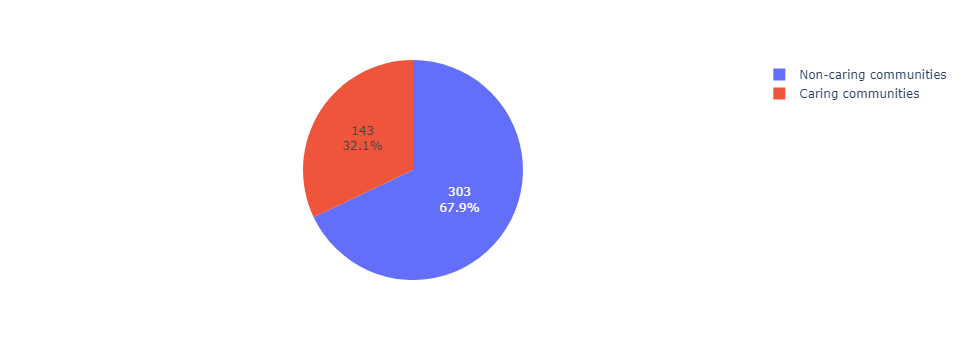

In [276]:
fig = px.pie(df_explore, names="label")
fig.update_traces(textposition='inside', textinfo='percent+value')
fig.show()

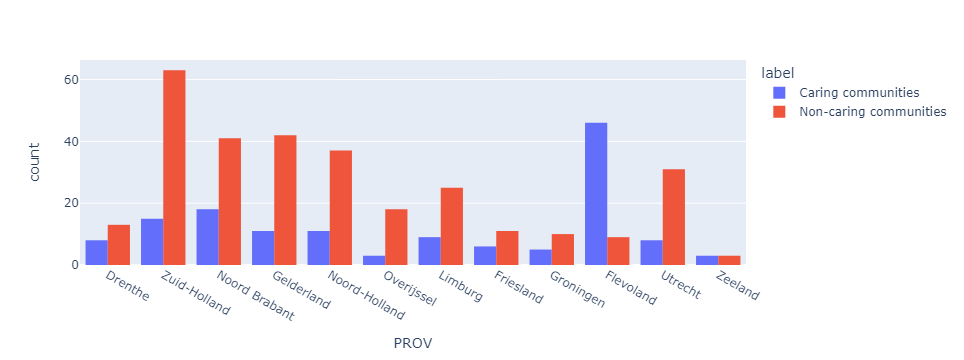

In [267]:
#dictionary mapping letter codes to descriptions
province_map = {
    "A": "Groningen",
    "B": "Friesland",
    "D": "Drenthe",
    "E": "Overijssel",
    "G": "Gelderland",
    "K": "Limburg",
    "P": "Noord Brabant",
    "S": "Zeeland",
    "H": "Zuid-Holland",
    "M": "Utrecht",
    "L": "Noord-Holland",
    "X": "Flevoland"
}

df_explore["PROV"] = df_explore["PROV"].map(province_map)

fig = px.histogram(df_explore, x="PROV", color="label", barmode='group')
fig.show()

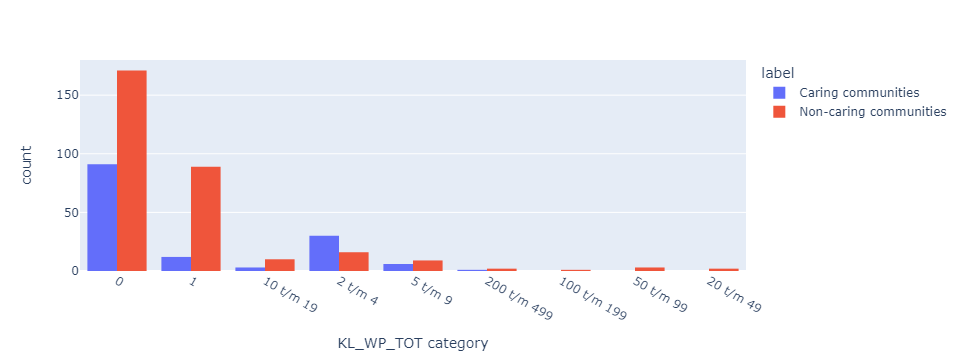

In [268]:
def map_categories(value):
    if value == 1.0:
        return "0"
    elif value == 2.0:
        return "1"
    elif value == 3.0:
        return "2 t/m 4"
    elif value == 4.0:
        return "5 t/m 9"
    elif value == 5.0:
        return "10 t/m 19"
    elif value == 6.0:
        return "20 t/m 49"
    elif value == 7.0:
        return "50 t/m 99"
    elif value == 8.0:
        return "100 t/m 199"
    elif value == 9.0:
        return "200 t/m 499"
        
    else:
        return "Unknown"

#map numerical values in 'KL_WP_TOT' column to categories
df_explore['KL_WP_TOT_category'] = df_explore['KL_WP_TOT'].apply(map_categories)

fig = px.histogram(df_explore, x="KL_WP_TOT_category", color="label", barmode='group')
fig.update_layout(bargap=0.2, xaxis_title_text='KL_WP_TOT category')
fig.show()

C:\Users\TesselsLisa\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



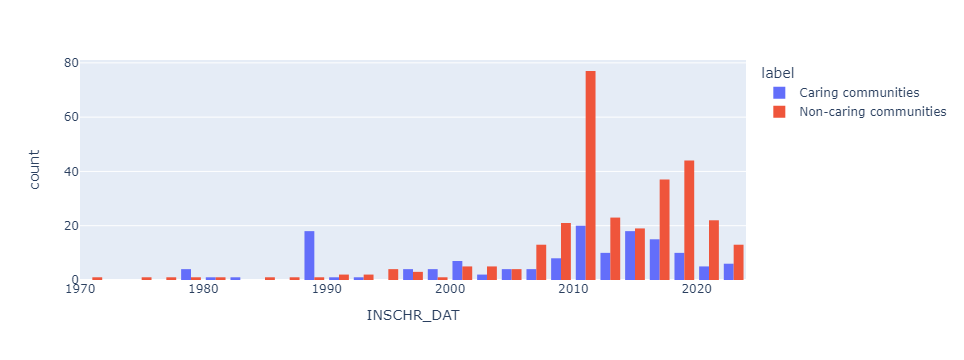

In [269]:
fig = px.histogram(df_explore, x="INSCHR_DAT", color="label", nbins=50, barmode='group')
fig.show()

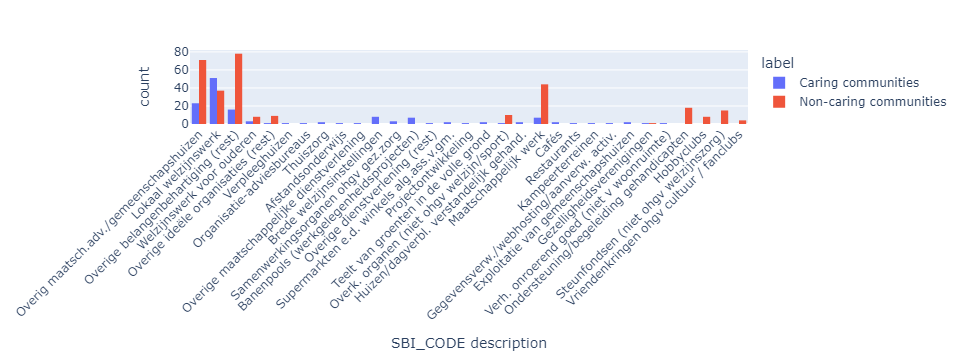

In [270]:
fig = px.histogram(df_explore, x="SBI_OMSCHR", color="label", barmode='group')

fig.update_layout(
    xaxis_title="SBI_CODE description",
    xaxis_tickangle=-45,  #rotate x-axis labels for better readability
    margin=dict(t=50)  #increase the top margin to provide space for the title
)

fig.show()

In [271]:
rechtsvorm_order = df_explore['RECHTSVORM'].unique()
rechtsvorm_order

array([ 7., 71., 61., 74.,  1., 41., 11., 70.])

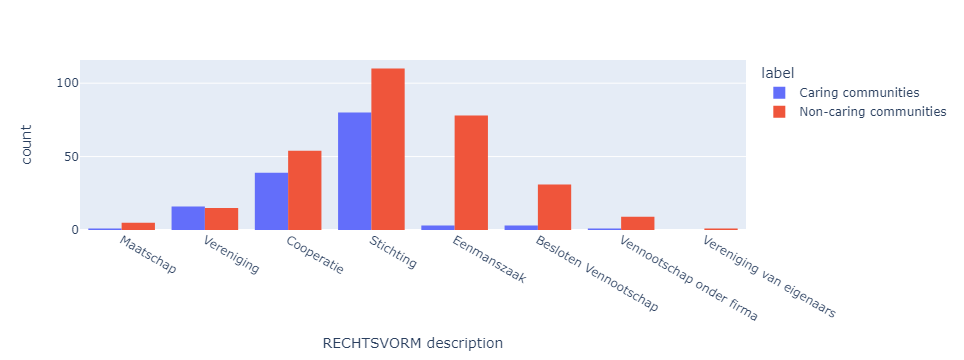

In [274]:
rechtsvorm_map = {
    7.0: "Maatschap",  
    71.0: "Vereniging",
    61.0: "Cooperatie",
    74.0: "Stichting",
    1.0: "Eenmanszaak",  
    41.0: "Besloten Vennootschap",
    11.0: "Vennootschap onder firma",
    70.0: "Vereniging van eigenaars"  
}

#map the numerical values in the 'RECHTSVORM' column to their descriptions using the dictionary
df_explore["RECHTSVORM_description"] = df_explore["RECHTSVORM"].map(rechtsvorm_map)

fig = px.histogram(df_explore, x="RECHTSVORM_description", color="label", barmode='group')
fig.update_layout(xaxis_title_text='RECHTSVORM description')
fig.show()

# Pre-processing 

#### One-hot encode SBI codes

In [277]:
#print all unique SBI codes in KVK data from 2023
df_KVK2023['SBI_CODE'].unique()

array([94996, 64922, 88999, 94997,  5621,  8720, 86919, 85592,  6831,
       93112, 94995, 70221, 88992, 94991, 94993,  4334, 88993, 88103,
       94994, 94992, 69203,  8891, 88991, 86929, 47789, 85522,  3102,
        7312, 96022, 88101, 88102, 86922,  6202, 91011,  9002, 85519,
        8292,  8130, 69209,  9609,  9604, 56102,  9003,  7112, 90011,
        7430, 93299, 86913,  6420, 70102, 85599, 74101,  1411,  8219,
       74201,   150, 69101,  8121, 77292, 68204, 71111, 45402, 64302,
       72191, 85314, 87901, 93125,  7490, 86104, 59111, 74103, 96021,
        5630,  3109, 68203,  7721,  6312, 47521,  1422, 47919,  4120,
       69102, 45205,  5629,  2599,  5030, 93127,  5530, 47999,  3213,
       85521,  8710,  7311, 55101, 49393, 93119, 91022,  1305, 46734,
       47431, 45112, 93121,  8541, 86102,  7021,  7810,  6209, 66191,
       70222, 93195,  2562,  3220,  5811,  1302, 93111,  9313,  1473,
       72192, 96031, 93199,  9411, 87301,  1451,   143,  1421, 64923,
        2229, 68201,

In [278]:
#looping through the SBI_CODE, NEVENACT_1 and NEVENACT_2 and only keeping the SBI code from the selection based on KVK2022

#selection of important SBI codes
important_codes = {88102, 88103, 88992, 88993, 88999, 94991, 
                   94992, 94993, 94994, 94995, 94996, 94997}

#function to determine the appropriate SBI code to keep
def choose_sbi(row):
    sbi_code = None
    if row['SBI_CODE'] in important_codes:
        sbi_code = row['SBI_CODE']
    elif row['NEVENACT_1'] in important_codes:
        sbi_code = row['NEVENACT_1']
    elif row['NEVENACT_2'] in important_codes:
        sbi_code = row['NEVENACT_2']
    #convert selected SBI code to integer if not None
    return int(sbi_code) if sbi_code is not None else None

#function to apply the above logic to each row in the df
def select_important_sbi(df):
    #create a new column 'Selected_SBI' with the selected SBI code
    df['Selected_SBI'] = df.apply(choose_sbi, axis=1)
    #convert 'Selected_SBI' column to integer type
    df['Selected_SBI'] = df['Selected_SBI'].astype('Int64')  # Use 'Int64' for nullable integer type
    return df

result_df = select_important_sbi(df_KVK2023)

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\1741243457.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\1741243457.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [279]:
#drop the unnecessary columns SBI_CODE, NEVENACT_1, NEVENACT_2
df_KVK2023 = result_df.drop(['SBI_CODE', 'NEVENACT_1', 'NEVENACT_2'], axis=1)

In [280]:
df_KVK2023

,VGNUMMER,HN45,PROV,W_P_TOTAAL,RECHTSVORM,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,Selected_SBI
0,9058125,Kinderoord Schaarshoek B.V.,E,40,41,Kinderoord Schaarshoek B.V.,Het verschaffen en instandhouden van voorzieni...,2022,3,29,94996
1,15522539,Stichting Kredietbank Nederland,B,120,74,Stichting Kredietbank Nederland,Het verstrekken van leningen aan particulieren...,1965,3,10,88999
2,12799750,Stichting Mienskipssintrum It GeaHûs,B,6,74,Stichting Mienskipssintrum It GeaHûs,"Oprichting, instandhouding en exploiteren van ...",1965,9,30,88999
3,15246132,Coöperatie 'De Grachten' coöperatief UA,B,0,61,Coöperatie 'De Grachten' coöperatief UA,De behartiging van de stoffelijke belangen van...,1974,9,11,94997
4,8429855,Coöp. Ver. Recr.won.complex Sluskes Schar UA,B,0,61,Coöperatieve Vereniging Recreatiewoningencompl...,Het behartigen van de gemeenschappelijke belan...,1975,1,8,94997
...,...,...,...,...,...,...,...,...,...,...,...
11262,57777969,Van Leeuwenkracht,S,1,1,Van Leeuwenkracht,Leefstijl- en vitaliteitscoach. Sportmassage. ...,2023,12,1,88999
11263,37020862,BalansZorg B.V.,G,1,41,BalansZorg B.V.,"Thuiszorg en ambulante hulpverlening, maatscha...",2023,12,1,88992
11264,57816638,Levazorg plus B.V.,L,1,41,Levazorg plus B.V.,Het aanbieden van opvang met begeleiding. Jeug...,2023,12,6,88992
11265,57818436,Return to Sender B.V.,G,0,41,Return to Sender B.V.,"Het ontwerpen, de productie en in- en verkoop ...",2023,12,6,94996


In [282]:
KVK2022 = df_KVK2022
KVK2023 = df_KVK2023
label = df_labelled

#add df identifiers to each df
KVK2022['DataFrame'] = 'KVK2022'
KVK2023['DataFrame'] = 'KVK2023'
label['DataFrame'] = 'label'

#merge the dataframes
combined_df = pd.concat([KVK2022, KVK2023, label])

#calculate overall frequency of each SBI_CODE / Selected_SBI
total_counts_sbi_code = combined_df[combined_df['DataFrame'] != 'KVK2023']['SBI_CODE'].value_counts()
total_counts_selected_sbi = combined_df[combined_df['DataFrame'] == 'KVK2023']['Selected_SBI'].value_counts()

#combine the total_counts into a single Series
total_counts = pd.concat([total_counts_sbi_code, total_counts_selected_sbi], axis=0).groupby(level=0).sum()

#calculate frequency of each SBI_CODE / Selected_SBI in each df
df_counts = pd.DataFrame(index=total_counts.index)
for df_name in ['KVK2022', 'KVK2023', 'label']:
    if df_name == 'KVK2023':
        col_name = 'Selected_SBI'
    else:
        col_name = 'SBI_CODE'
        
    df_specific_counts = combined_df[combined_df['DataFrame'] == df_name][col_name].value_counts()
    df_counts[df_name] = df_specific_counts.reindex(df_counts.index, fill_value=0)

#merge total counts and df-specific counts
merged_counts = pd.concat([total_counts.rename('Total'), df_counts], axis=1)

#sort the merged_counts DataFrame by the 'Total' column in descending order
merged_counts_sorted = merged_counts.sort_values(by='Total', ascending=False)

#display the whole merged counts table sorted
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_counts_sorted)

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\3650538222.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total,KVK2022,KVK2023,label
88999.0,5098,2098,2906,94
88993.0,3592,1610,1894,88
88992.0,3017,1073,1893,51
94997.0,2550,1132,1324,94
88103.0,1911,616,1277,18
88102.0,714,214,489,11
94993.0,507,214,278,15
94992.0,483,172,303,8
94996.0,465,209,246,10
94995.0,464,198,255,11


The table shows that below a frequency of 162, the sbi codes only occur in the training dataset and not the KVK2022 or the KVK2023. So, we decided to group all the sbi codes with a frequency below 100 to minimize the complexity of the model after one-hot encoding this variable.

In [283]:
df_KVK2022['SBI_CODE'].unique()

array([88102, 88103, 88992, 88993, 88999, 94991, 94992, 94993, 94994,
       94995, 94996, 94997], dtype=int64)

In [284]:
df_KVK2023['Selected_SBI'].unique()

<IntegerArray>
[94996, 88999, 94997, 94992, 88102, 88992, 94995, 94991, 94993, 88103, 88993,
 94994]
Length: 12, dtype: Int64

In [285]:
#one-hot encode the 'Selected_SBI' column in KVK2023
one_hot_encoded = pd.get_dummies(df_KVK2023['Selected_SBI'], prefix='SBI')

#convert boolean values to integers (0 or 1)
one_hot_encoded = one_hot_encoded.astype(int)

#concatenate the one-hot encoded df with the original df
df_KVK2023_encoded = pd.concat([df_KVK2023, one_hot_encoded], axis=1)

#drop the unnecessary columns Selected_SBI and DataFrame
df_KVK2023_encoded = df_KVK2023_encoded.drop(['Selected_SBI', 'DataFrame'], axis=1)

#add empty column at the end to match the column in the training dataset df_labelled
df_KVK2023_encoded['SBI_overig'] = 0

df_KVK2023_encoded

,VGNUMMER,HN45,PROV,W_P_TOTAAL,RECHTSVORM,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,...,SBI_88993,SBI_88999,SBI_94991,SBI_94992,SBI_94993,SBI_94994,SBI_94995,SBI_94996,SBI_94997,SBI_overig
0,9058125,Kinderoord Schaarshoek B.V.,E,40,41,Kinderoord Schaarshoek B.V.,Het verschaffen en instandhouden van voorzieni...,2022,3,29,...,0,0,0,0,0,0,0,1,0,0
1,15522539,Stichting Kredietbank Nederland,B,120,74,Stichting Kredietbank Nederland,Het verstrekken van leningen aan particulieren...,1965,3,10,...,0,1,0,0,0,0,0,0,0,0
2,12799750,Stichting Mienskipssintrum It GeaHûs,B,6,74,Stichting Mienskipssintrum It GeaHûs,"Oprichting, instandhouding en exploiteren van ...",1965,9,30,...,0,1,0,0,0,0,0,0,0,0
3,15246132,Coöperatie 'De Grachten' coöperatief UA,B,0,61,Coöperatie 'De Grachten' coöperatief UA,De behartiging van de stoffelijke belangen van...,1974,9,11,...,0,0,0,0,0,0,0,0,1,0
4,8429855,Coöp. Ver. Recr.won.complex Sluskes Schar UA,B,0,61,Coöperatieve Vereniging Recreatiewoningencompl...,Het behartigen van de gemeenschappelijke belan...,1975,1,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,57777969,Van Leeuwenkracht,S,1,1,Van Leeuwenkracht,Leefstijl- en vitaliteitscoach. Sportmassage. ...,2023,12,1,...,0,1,0,0,0,0,0,0,0,0
11263,37020862,BalansZorg B.V.,G,1,41,BalansZorg B.V.,"Thuiszorg en ambulante hulpverlening, maatscha...",2023,12,1,...,0,0,0,0,0,0,0,0,0,0
11264,57816638,Levazorg plus B.V.,L,1,41,Levazorg plus B.V.,Het aanbieden van opvang met begeleiding. Jeug...,2023,12,6,...,0,0,0,0,0,0,0,0,0,0
11265,57818436,Return to Sender B.V.,G,0,41,Return to Sender B.V.,"Het ontwerpen, de productie en in- en verkoop ...",2023,12,6,...,0,0,0,0,0,0,0,1,0,0


In [286]:
#one-hot encode the 'SBI_CODE' column in KVK2022
one_hot_encoded = pd.get_dummies(df_KVK2022['SBI_CODE'], prefix='SBI')

#convert boolean values to integers (0 or 1)
one_hot_encoded = one_hot_encoded.astype(int)

#concatenate the one-hot encoded df with the original df
df_KVK2022_encoded = pd.concat([df_KVK2022, one_hot_encoded], axis=1)

#drop the unnecessary columns SBI_CODE and DataFrame
df_KVK2022_encoded = df_KVK2022_encoded.drop(['SBI_CODE', 'DataFrame'], axis=1)

#add empty column at the end to match the column in the training dataset df_labelled
df_KVK2022_encoded['SBI_overig'] = 0

df_KVK2022_encoded

,VGNUMMER,HN45,PROV,RECHTSVORM,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,...,SBI_88993,SBI_88999,SBI_94991,SBI_94992,SBI_94993,SBI_94994,SBI_94995,SBI_94996,SBI_94997,SBI_overig
0,37667726,Wijkvereniging De Watertoren,B,71,0,Wijkvereniging De Watertoren,Dagbesteding.,2017,7,31,...,0,0,0,0,0,0,0,0,0,0
1,14741156,Dienstverleningsbedrijf Kromkamp,B,11,2,Dienstverleningsbedrijf Kromkamp,Verzorgende IG. Masseuse. Chauffeursdiensten. ...,2007,6,12,...,0,0,0,0,0,0,0,0,0,0
2,7090218,WijZ,E,74,25,WijZ,Instelling actief op het terrein van het bevor...,1990,12,28,...,0,0,0,0,0,0,0,0,0,0
3,22172068,K.B.O.,E,71,0,K.B.O.,Welzijnswerk voor ouderen.,2011,3,8,...,0,0,0,0,0,0,0,0,0,0
4,40682250,St. ICOO Intercultur. Ouderen Organisatie Ov.,E,74,0,Stichting ICOO Interculturele Ou,Het bevorderen van interculturele zorg en welz...,2018,9,14,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002,52495817,Coöperat. Bensell Real Est. Investment VI BA,L,61,0,Coöperatie Bensell Real Estate I,De Coöperatie heeft ten doel te voorzien in de...,2022,5,30,...,0,0,0,0,0,0,0,0,1,0
8003,52756122,Influencer Capital Coöperatief UA,L,61,0,Influencer Capital Coöperatief U,De Coöperatie heeft ten doel het voorzien in b...,2022,6,27,...,0,0,0,0,0,0,0,0,1,0
8004,52767973,CPO Niedorp,L,61,0,CPO Niedorp,Het voorzien in bepaalde stoffelijke behoeften...,2022,6,28,...,0,0,0,0,0,0,0,0,1,0
8006,52929000,Energiecoöperatie BreedSaam UA,P,61,0,Energiecoöperatie BreedSaam UA,Voorzien in bepaalde stoffelijke behoeften van...,2022,7,13,...,0,0,0,0,0,0,0,0,1,0


In [287]:
#one-hot encode the SBI column in df_labelled while grouping the codes with a frequency below 100

#merge the DataFrames with identifiers
df_KVK2022['DataFrame'] = 'KVK2022'
df_KVK2023['DataFrame'] = 'KVK2023'
df_labelled['DataFrame'] = 'labelled'

#concatenate the dataframes
combined_df = pd.concat([df_KVK2022, df_KVK2023, df_labelled])

#calculate overall frequency of each SBI_CODE / Selected_SBI
total_counts_sbi_code = combined_df[combined_df['DataFrame'] != 'KVK2023']['SBI_CODE'].value_counts()
total_counts_selected_sbi = combined_df[combined_df['DataFrame'] == 'KVK2023']['Selected_SBI'].value_counts()

#combine the total_counts into a single Series
total_counts = pd.concat([total_counts_sbi_code, total_counts_selected_sbi], axis=0).groupby(level=0).sum()

#identify SBI codes with frequency below 100 and group them as 'overig'
low_freq_sbis = total_counts[total_counts < 100].index
combined_df.loc[combined_df['SBI_CODE'].isin(low_freq_sbis), 'SBI_CODE'] = 'overig'

#initialize df to store frequency counts for each category
df_counts = pd.DataFrame(index=combined_df['SBI_CODE'].unique())

#calculate frequency of each SBI_CODE / Selected_SBI in each df after grouping low-frequency SBIs
for df_name in ['KVK2022', 'KVK2023', 'labelled']:
    if df_name == 'KVK2023':
        col_name = 'Selected_SBI'
    else:
        col_name = 'SBI_CODE'
    
    #filter rows for the specific DataFrame
    df_specific = combined_df[combined_df['DataFrame'] == df_name]
    
    #calculate value counts for the specific column
    df_specific_counts = df_specific[col_name].value_counts()
    
    #update df_counts with specific counts (reindex to include all unique categories)
    df_counts[df_name] = df_specific_counts.reindex(df_counts.index, fill_value=0)

#add 'overig' category with zeros to df_counts if it doesn't exist
if 'overig' not in df_counts.index:
    df_counts.loc['overig'] = 0

#sort the merged counts df by the 'Total' column in descending order
merged_counts_sorted = total_counts.rename('Total').sort_values(ascending=False)

#display the whole merged counts table sorted
#with pd.option_context('display.max_rows', None):
#    display(merged_counts_sorted)

#one-hot encode the 'SBI_CODE' column in df_labelled (after grouping 'overig')
one_hot_encoded = pd.get_dummies(df_labelled['SBI_CODE'].replace(low_freq_sbis, 'overig'), prefix='SBI')

#convert boolean values to integers (0 or 1)
one_hot_encoded = one_hot_encoded.astype(int)

#concatenate the one-hot encoded DataFrame with the original DataFrame (df_labelled)
df_labelled_encoded = pd.concat([df_labelled, one_hot_encoded], axis=1)

#drop the unnecessary columns SBI_CODE and DataFrame
df_labelled_encoded = df_labelled_encoded.drop(['SBI_CODE', 'DataFrame'], axis=1)

df_labelled_encoded

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\3573732819.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\TesselsLisa\AppData\Local\Temp\ipykernel_19344\3573732819.py:20: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'overig' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



,HN45,PROV,RECHTSVORM,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,label,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,...,SBI_88993,SBI_88999,SBI_94991,SBI_94992,SBI_94993,SBI_94994,SBI_94995,SBI_94996,SBI_94997,SBI_overig
3,Maatschap Beheer MFC Tiendeveen,D,7,0,Maatschap Beheer MFC Tiendeveen,Het beheren van het Multifunctioneel Centrum i...,1,2013,3,14,...,0,1,0,0,0,0,0,0,0,0
4,Aktiviteitencentrum Alletahof,H,71,0,Aktiviteitencentrum Alletahof,Buurt- en clubhuiswerk en samenlevingsopbouwwerk,1,2011,2,16,...,1,0,0,0,0,0,0,0,0,0
5,Coöperatie Stationspark Deurne UA,P,61,0,Coöperatie Stationspark Deurne U,"De kwaliteit van de woon-, werk- en leefomgevi...",1,2014,12,23,...,0,0,0,0,0,0,0,0,1,0
6,Coöperatie Sustar UA,G,61,0,Coöperatie Sustar UA,Het bieden van ondersteuning aan organisaties ...,1,2022,7,1,...,0,0,0,0,0,0,0,0,1,0
7,"Jasmijnsteede, Centraal wonen voor ouderen",D,71,0,"Jasmijnsteede, Centraal wonen vo",Groepswonen voor ouderen.,1,2011,4,20,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,Verenig. Groepsw. van Oud. 'Ouder-Landshoek',H,71,0,Vereniging Groepswonen van Ouder,Bejaardenverenigingen,1,1990,3,6,...,0,0,1,0,0,0,0,0,0,0
253,Bewonersvereniging Centraal Wonen 'De Banier',H,71,0,Bewonersvereniging Centraal Wone,Verhuur van onroerend goed,1,1979,10,26,...,0,0,0,0,0,0,0,0,0,1
257,Stichting Dorpsraad Ven-Zelderheide,K,74,5,Stichting Dorpsraad Ven-Zelderhe,"Belangenverenigingen, meer bezighouden met ge-...",1,1981,6,26,...,0,0,0,0,0,0,0,0,1,0
262,Stichting Wijkraad Loven-Besterd,P,74,0,Stichting Wijkraad Loven-Besterd,Buurthuiswerk en samenlevingsopbouwwerk,1,1988,7,4,...,1,0,0,0,0,0,0,0,0,0


#### One-hot encode PROV (provincie)

In [288]:
#one-hot encode the 'PROV' column in KVK2022
one_hot_encoded = pd.get_dummies(df_KVK2022_encoded['PROV'], prefix='PROV')

#convert boolean values to integers (0 or 1)
one_hot_encoded = one_hot_encoded.astype(int)

#concatenate the one-hot encoded df with the original df
df_KVK2022_encoded = pd.concat([df_KVK2022_encoded, one_hot_encoded], axis=1)

#drop the unnecessary column PROV
df_KVK2022_encoded = df_KVK2022_encoded.drop(['PROV'], axis=1)

df_KVK2022_encoded

,VGNUMMER,HN45,RECHTSVORM,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,...,PROV_D,PROV_E,PROV_G,PROV_H,PROV_K,PROV_L,PROV_M,PROV_P,PROV_S,PROV_X
0,37667726,Wijkvereniging De Watertoren,71,0,Wijkvereniging De Watertoren,Dagbesteding.,2017,7,31,1,...,0,0,0,0,0,0,0,0,0,0
1,14741156,Dienstverleningsbedrijf Kromkamp,11,2,Dienstverleningsbedrijf Kromkamp,Verzorgende IG. Masseuse. Chauffeursdiensten. ...,2007,6,12,1,...,0,0,0,0,0,0,0,0,0,0
2,7090218,WijZ,74,25,WijZ,Instelling actief op het terrein van het bevor...,1990,12,28,1,...,0,1,0,0,0,0,0,0,0,0
3,22172068,K.B.O.,71,0,K.B.O.,Welzijnswerk voor ouderen.,2011,3,8,1,...,0,1,0,0,0,0,0,0,0,0
4,40682250,St. ICOO Intercultur. Ouderen Organisatie Ov.,74,0,Stichting ICOO Interculturele Ou,Het bevorderen van interculturele zorg en welz...,2018,9,14,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8002,52495817,Coöperat. Bensell Real Est. Investment VI BA,61,0,Coöperatie Bensell Real Estate I,De Coöperatie heeft ten doel te voorzien in de...,2022,5,30,0,...,0,0,0,0,0,1,0,0,0,0
8003,52756122,Influencer Capital Coöperatief UA,61,0,Influencer Capital Coöperatief U,De Coöperatie heeft ten doel het voorzien in b...,2022,6,27,0,...,0,0,0,0,0,1,0,0,0,0
8004,52767973,CPO Niedorp,61,0,CPO Niedorp,Het voorzien in bepaalde stoffelijke behoeften...,2022,6,28,0,...,0,0,0,0,0,1,0,0,0,0
8006,52929000,Energiecoöperatie BreedSaam UA,61,0,Energiecoöperatie BreedSaam UA,Voorzien in bepaalde stoffelijke behoeften van...,2022,7,13,0,...,0,0,0,0,0,0,0,1,0,0


In [289]:
#one-hot encode the 'PROV' column in KVK2023
one_hot_encoded = pd.get_dummies(df_KVK2023_encoded['PROV'], prefix='PROV')

#convert boolean values to integers (0 or 1)
one_hot_encoded = one_hot_encoded.astype(int)

#concatenate the one-hot encoded df with the original df
df_KVK2023_encoded = pd.concat([df_KVK2023_encoded, one_hot_encoded], axis=1)

#drop the unnecessary column PROV
df_KVK2023_encoded = df_KVK2023_encoded.drop(['PROV'], axis=1)

df_KVK2023_encoded

,VGNUMMER,HN45,W_P_TOTAAL,RECHTSVORM,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,...,PROV_D,PROV_E,PROV_G,PROV_H,PROV_K,PROV_L,PROV_M,PROV_P,PROV_S,PROV_X
0,9058125,Kinderoord Schaarshoek B.V.,40,41,Kinderoord Schaarshoek B.V.,Het verschaffen en instandhouden van voorzieni...,2022,3,29,0,...,0,1,0,0,0,0,0,0,0,0
1,15522539,Stichting Kredietbank Nederland,120,74,Stichting Kredietbank Nederland,Het verstrekken van leningen aan particulieren...,1965,3,10,0,...,0,0,0,0,0,0,0,0,0,0
2,12799750,Stichting Mienskipssintrum It GeaHûs,6,74,Stichting Mienskipssintrum It GeaHûs,"Oprichting, instandhouding en exploiteren van ...",1965,9,30,0,...,0,0,0,0,0,0,0,0,0,0
3,15246132,Coöperatie 'De Grachten' coöperatief UA,0,61,Coöperatie 'De Grachten' coöperatief UA,De behartiging van de stoffelijke belangen van...,1974,9,11,0,...,0,0,0,0,0,0,0,0,0,0
4,8429855,Coöp. Ver. Recr.won.complex Sluskes Schar UA,0,61,Coöperatieve Vereniging Recreatiewoningencompl...,Het behartigen van de gemeenschappelijke belan...,1975,1,8,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,57777969,Van Leeuwenkracht,1,1,Van Leeuwenkracht,Leefstijl- en vitaliteitscoach. Sportmassage. ...,2023,12,1,0,...,0,0,0,0,0,0,0,0,1,0
11263,37020862,BalansZorg B.V.,1,41,BalansZorg B.V.,"Thuiszorg en ambulante hulpverlening, maatscha...",2023,12,1,0,...,0,0,1,0,0,0,0,0,0,0
11264,57816638,Levazorg plus B.V.,1,41,Levazorg plus B.V.,Het aanbieden van opvang met begeleiding. Jeug...,2023,12,6,0,...,0,0,0,0,0,1,0,0,0,0
11265,57818436,Return to Sender B.V.,0,41,Return to Sender B.V.,"Het ontwerpen, de productie en in- en verkoop ...",2023,12,6,0,...,0,0,1,0,0,0,0,0,0,0


In [290]:
#one-hot encode the 'PROV' column in df_labelled
one_hot_encoded = pd.get_dummies(df_labelled_encoded['PROV'], prefix='PROV')

#convert boolean values to integers (0 or 1)
one_hot_encoded = one_hot_encoded.astype(int)

#concatenate the one-hot encoded df with the original df
df_labelled_encoded = pd.concat([df_labelled_encoded, one_hot_encoded], axis=1)

#drop the unnecessary column PROV
df_labelled_encoded = df_labelled_encoded.drop(['PROV'], axis=1)

df_labelled_encoded

,HN45,RECHTSVORM,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,label,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,...,PROV_D,PROV_E,PROV_G,PROV_H,PROV_K,PROV_L,PROV_M,PROV_P,PROV_S,PROV_X
3,Maatschap Beheer MFC Tiendeveen,7,0,Maatschap Beheer MFC Tiendeveen,Het beheren van het Multifunctioneel Centrum i...,1,2013,3,14,0,...,1,0,0,0,0,0,0,0,0,0
4,Aktiviteitencentrum Alletahof,71,0,Aktiviteitencentrum Alletahof,Buurt- en clubhuiswerk en samenlevingsopbouwwerk,1,2011,2,16,0,...,0,0,0,1,0,0,0,0,0,0
5,Coöperatie Stationspark Deurne UA,61,0,Coöperatie Stationspark Deurne U,"De kwaliteit van de woon-, werk- en leefomgevi...",1,2014,12,23,0,...,0,0,0,0,0,0,0,1,0,0
6,Coöperatie Sustar UA,61,0,Coöperatie Sustar UA,Het bieden van ondersteuning aan organisaties ...,1,2022,7,1,0,...,0,0,1,0,0,0,0,0,0,0
7,"Jasmijnsteede, Centraal wonen voor ouderen",71,0,"Jasmijnsteede, Centraal wonen vo",Groepswonen voor ouderen.,1,2011,4,20,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,Verenig. Groepsw. van Oud. 'Ouder-Landshoek',71,0,Vereniging Groepswonen van Ouder,Bejaardenverenigingen,1,1990,3,6,0,...,0,0,0,1,0,0,0,0,0,0
253,Bewonersvereniging Centraal Wonen 'De Banier',71,0,Bewonersvereniging Centraal Wone,Verhuur van onroerend goed,1,1979,10,26,0,...,0,0,0,1,0,0,0,0,0,0
257,Stichting Dorpsraad Ven-Zelderheide,74,5,Stichting Dorpsraad Ven-Zelderhe,"Belangenverenigingen, meer bezighouden met ge-...",1,1981,6,26,0,...,0,0,0,0,1,0,0,0,0,0
262,Stichting Wijkraad Loven-Besterd,74,0,Stichting Wijkraad Loven-Besterd,Buurthuiswerk en samenlevingsopbouwwerk,1,1988,7,4,0,...,0,0,0,0,0,0,0,1,0,0


#### One-hot encode rechtsvorm

In [291]:
df_labelled_encoded["RECHTSVORM"].nunique()
df_KVK2022_encoded["RECHTSVORM"].nunique()
df_KVK2023_encoded["RECHTSVORM"].nunique()

19

In [292]:
KVK2022 = df_KVK2022_encoded
KVK2023 = df_KVK2023_encoded
label = df_labelled_encoded

#add df identifiers to each df
KVK2022['DataFrame'] = 'KVK2022'
KVK2023['DataFrame'] = 'KVK2023'
label['DataFrame'] = 'label'

#merge the dataframes
combined_df = pd.concat([KVK2022, KVK2023, label])

#calculate overall frequency of each PROV
total_counts_prov = combined_df['RECHTSVORM'].value_counts()

#calculate frequency of each PROV in each df
df_counts = pd.DataFrame(index=total_counts_prov.index)
for df_name in ['KVK2022', 'KVK2023', 'label']:
    df_specific_counts = combined_df[combined_df['DataFrame'] == df_name]['RECHTSVORM'].value_counts()
    df_counts[df_name] = df_specific_counts.reindex(df_counts.index, fill_value=0)

#merge total counts and df-specific counts
merged_counts = pd.concat([total_counts_prov.rename('Total'), df_counts], axis=1)

#sort the merged_counts df by the 'Total' column in descending order
merged_counts_sorted = merged_counts.sort_values(by='Total', ascending=False)

#display the whole merged counts table sorted
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merged_counts_sorted)

,Total,KVK2022,KVK2023,label
RECHTSVORM,,,,
1,7459,2565,4813,81
74,5652,2567,2895,190
61,1800,809,898,93
41,1763,641,1088,34
71,1750,834,885,31
11,580,191,379,10
7,71,21,44,6
72,47,21,26,0
21,19,8,11,0


In [293]:
#combine all dataframes into one
all_dataframes = [df_KVK2022_encoded, df_KVK2023_encoded, df_labelled_encoded]
combined_df = pd.concat(all_dataframes)

#define the frequency threshold
frequency_threshold = 10

#calculate the overall frequency of each RECHTSVORM
total_counts = combined_df['RECHTSVORM'].value_counts()

#get the categories with frequency over the threshold
freq_over_threshold = total_counts[total_counts >= frequency_threshold].index.tolist()

#create a new column 'RECHTSVORM_overig' to store categories with frequency below the threshold
combined_df['overig'] = combined_df['RECHTSVORM'].apply(lambda x: x if x in freq_over_threshold else 'overig')

#perform one-hot encoding
one_hot_encoded = pd.get_dummies(combined_df['overig'])

#convert boolean values to integers (0 or 1)
one_hot_encoded = one_hot_encoded.astype(int)

#rename columns with the prefix 'rechtsvorm'
one_hot_encoded.columns = ['rechtsvorm_' + str(col) for col in one_hot_encoded.columns]

#combine the original dataframe with the one-hot encoded dataframe
combined_df = pd.concat([combined_df, one_hot_encoded], axis=1)

#drop unnecessary columns
combined_df.drop(['RECHTSVORM', 'overig'], axis=1, inplace=True)

#split the combined dataframe back into the original dataframes with the same columns
df_KVK2022_encoded_result = combined_df[combined_df['DataFrame'] == 'KVK2022'].drop('DataFrame', axis=1)
df_KVK2023_encoded_result = combined_df[combined_df['DataFrame'] == 'KVK2023'].drop('DataFrame', axis=1)
df_labelled_encoded_result = combined_df[combined_df['DataFrame'] == 'label'].drop('DataFrame', axis=1)

In [294]:
df_KVK2023_encoded_result.columns

Index(['VGNUMMER', 'HN45', 'W_P_TOTAAL', 'H_NAAM_VOL', 'Bedrijfsomschrijving',
       'INSCHR_DAT_JAAR', 'INSCHR_DAT_MAAND', 'INSCHR_DAT_DAG', 'SBI_88102',
       'SBI_88103', 'SBI_88992', 'SBI_88993', 'SBI_88999', 'SBI_94991',
       'SBI_94992', 'SBI_94993', 'SBI_94994', 'SBI_94995', 'SBI_94996',
       'SBI_94997', 'SBI_overig', 'PROV_A', 'PROV_B', 'PROV_D', 'PROV_E',
       'PROV_G', 'PROV_H', 'PROV_K', 'PROV_L', 'PROV_M', 'PROV_P', 'PROV_S',
       'PROV_X', 'label', 'rechtsvorm_1', 'rechtsvorm_7', 'rechtsvorm_11',
       'rechtsvorm_21', 'rechtsvorm_41', 'rechtsvorm_61', 'rechtsvorm_70',
       'rechtsvorm_71', 'rechtsvorm_72', 'rechtsvorm_74', 'rechtsvorm_88',
       'rechtsvorm_overig'],
      dtype='object')

In [295]:
df_KVK2022_encoded_result.columns

Index(['VGNUMMER', 'HN45', 'W_P_TOTAAL', 'H_NAAM_VOL', 'Bedrijfsomschrijving',
       'INSCHR_DAT_JAAR', 'INSCHR_DAT_MAAND', 'INSCHR_DAT_DAG', 'SBI_88102',
       'SBI_88103', 'SBI_88992', 'SBI_88993', 'SBI_88999', 'SBI_94991',
       'SBI_94992', 'SBI_94993', 'SBI_94994', 'SBI_94995', 'SBI_94996',
       'SBI_94997', 'SBI_overig', 'PROV_A', 'PROV_B', 'PROV_D', 'PROV_E',
       'PROV_G', 'PROV_H', 'PROV_K', 'PROV_L', 'PROV_M', 'PROV_P', 'PROV_S',
       'PROV_X', 'label', 'rechtsvorm_1', 'rechtsvorm_7', 'rechtsvorm_11',
       'rechtsvorm_21', 'rechtsvorm_41', 'rechtsvorm_61', 'rechtsvorm_70',
       'rechtsvorm_71', 'rechtsvorm_72', 'rechtsvorm_74', 'rechtsvorm_88',
       'rechtsvorm_overig'],
      dtype='object')

In [296]:
df_labelled_encoded_result.columns

Index(['VGNUMMER', 'HN45', 'W_P_TOTAAL', 'H_NAAM_VOL', 'Bedrijfsomschrijving',
       'INSCHR_DAT_JAAR', 'INSCHR_DAT_MAAND', 'INSCHR_DAT_DAG', 'SBI_88102',
       'SBI_88103', 'SBI_88992', 'SBI_88993', 'SBI_88999', 'SBI_94991',
       'SBI_94992', 'SBI_94993', 'SBI_94994', 'SBI_94995', 'SBI_94996',
       'SBI_94997', 'SBI_overig', 'PROV_A', 'PROV_B', 'PROV_D', 'PROV_E',
       'PROV_G', 'PROV_H', 'PROV_K', 'PROV_L', 'PROV_M', 'PROV_P', 'PROV_S',
       'PROV_X', 'label', 'rechtsvorm_1', 'rechtsvorm_7', 'rechtsvorm_11',
       'rechtsvorm_21', 'rechtsvorm_41', 'rechtsvorm_61', 'rechtsvorm_70',
       'rechtsvorm_71', 'rechtsvorm_72', 'rechtsvorm_74', 'rechtsvorm_88',
       'rechtsvorm_overig'],
      dtype='object')

In [297]:
df_KVK2022 = df_KVK2022_encoded_result
df_KVK2023 = df_KVK2023_encoded_result
df_labelled = df_labelled_encoded_result

## Text pre-processing

In [298]:
#identify text columns
text_columns = ['HN45', 'H_NAAM_VOL', 'Bedrijfsomschrijving']

def preprocess_text(text):
    #tokenization
    tokens = word_tokenize(text)
    
    #normalization (turn into lower case)
    tokens = [token.lower() for token in tokens]
    
    #remove URLs, emojis, numbers etc.
    tokens = [re.sub(r'http\S+', '', token) for token in tokens]  # Remove URLs
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]  # Remove punctuation
    tokens = [token for token in tokens if token.isalpha()]  # Remove numbers
    
    #remove stop words
    stop_words = set(stopwords.words('dutch'))  # You can replace 'english' with the appropriate language
    tokens = [token for token in tokens if token not in stop_words]
    
    #unicode normalization
    tokens = [unicodedata.normalize('NFKD', token).encode('ascii', 'ignore').decode('utf-8') for token in tokens]
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [299]:
#apply preprocessing to each text column
for col in text_columns:
    df_labelled[col] = df_labelled[col].apply(preprocess_text)

### Turn into BoW

In [300]:
#combine all text columns into one
df_labelled['combined_text'] = df_labelled[text_columns].apply(lambda row: ' '.join(row), axis=1)
  
#initialize CountVectorizer
vectorizer = CountVectorizer()
   
#fit and transform the combined text column into bow
bow = vectorizer.fit_transform(df_labelled['combined_text'])
    
#get feature names
feature_names = vectorizer.get_feature_names_out()

Optimal number of topics (k): 11


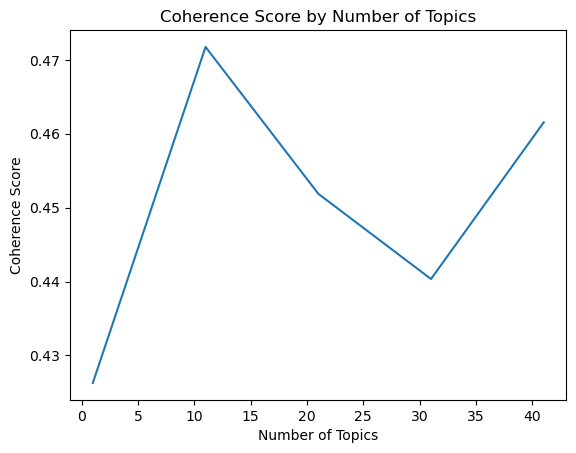

In [301]:
documents = df_labelled['combined_text'].tolist()
 
#fit feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()
#fit and transform the combined text column into BoW
bow = vectorizer.fit_transform(documents)
 
#create a Gensim dictionary from the feature names
tokenized_docs = [doc.split() for doc in documents]
dictionary = corpora.Dictionary(tokenized_docs)
 
#convert BoW matrix to Gensim corpus (Bag-of-Words format)
corpus = [dictionary.doc2bow(doc.split()) for doc in documents]
 
#define function to compute coherence score
def compute_coherence_values(corpus, dictionary, k, texts):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()
 
#define range of k values
min_k = 1
max_k = 50
step = 10
k_values = range(min_k, max_k + 1, step)
 
#compute coherence scores for different k values
coherence_values = []
for k in k_values:
    coherence_score = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k, texts=tokenized_docs)
    coherence_values.append(coherence_score)
 
#find optimal k with highest coherence score
optimal_k = k_values[np.argmax(coherence_values)]
print("Optimal number of topics (k):", optimal_k)
 
#plot coherence values to visualize
plt.plot(k_values, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics")
plt.show()

The coherence score seems to keep increasing with the number of topics, so it makes better sense to pick the model that gave the highest CV before  a major drop. In this case, the optimal number of topics is K=11

In [302]:
#topic modeling using the LDA algorithm
LDA = LatentDirichletAllocation(n_components=11, random_state=0)
LDA.fit_transform(bow)

array([[0.00699308, 0.00699337, 0.00699345, ..., 0.00699309, 0.0069933 ,
        0.00699331],
       [0.01136364, 0.88636156, 0.01136482, ..., 0.01136364, 0.01136403,
        0.01136387],
       [0.00378792, 0.00378796, 0.00378802, ..., 0.9621203 , 0.00378793,
        0.00378789],
       ...,
       [0.0082649 , 0.00826477, 0.00826466, ..., 0.00826471, 0.00826446,
        0.91735271],
       [0.01010136, 0.01010164, 0.0101017 , ..., 0.01010113, 0.01010125,
        0.01010176],
       [0.01010136, 0.01010159, 0.01010157, ..., 0.01010113, 0.01010118,
        0.89898668]])

In [303]:
#rows correspond to topics, and columns correspond to words 
#values indicate the importance of each word in each topic
print(LDA.components_)

[[0.09090909 0.09090909 2.09091206 ... 0.09090909 0.09090909 0.09090909]
 [0.09090909 0.09090909 0.09091138 ... 0.09090909 0.09090909 0.09090909]
 [0.09090909 0.09090909 4.59163623 ... 0.09090909 0.09090909 0.09090909]
 ...
 [0.09090909 0.09092851 0.19457186 ... 0.09090909 0.09090909 1.09090909]
 [0.09090909 0.09090909 0.09090909 ... 0.09090909 0.09090909 0.09090909]
 [0.09090909 0.09090909 3.09091166 ... 0.09090909 1.09090909 0.09090909]]


In [304]:
#iterate over each topic learned by the LDA model and print the top 15 most important words for each topic.
#each topic is represented by a list of words based on their importance in the topic.
for i, t in enumerate(LDA.components_):
  hottopics = t.argsort()[:-15 -1:-1 ]
  print("Topic {}".format(i + 1) + " " + " ".join([feature_names[j] for j in hottopics]))

Topic 1 stichting gemeenschapshuis overkoepelende adviesorganen organen samenwerkings gebied exploitatie welzijnswerk delft activiteiten thuiszorg fonds fondsen ouderen
Topic 2 stichting ua zorgcooperatie dorp beheren kwetsbare werk wonen bevorderen buurt dagbesteding blijven maatschappelijke welzijn mensen
Topic 3 stichting buurt gebied vereniging ua bv begeleiding leden cooperatie alsmede ten diensten doel cooperatieve alle
Topic 4 mensen stichting begeleiding geven beperking bv hulp coaching stellen trainingen maken ondersteunen financiele maatschap maatschappelijke
Topic 5 stichting ua leden cooperatie cooperatieve enof vereniging belangen activiteiten coop ondersteunen filosoferen ter ondersteuning sociale
Topic 6 leden cooperatie ua buurtcentrum ten overeenkomsten behoeve stoffelijke behoeften bedrijf uitoefenen einde belangen doet uitoefent
Topic 7 stichting zorg welzijn begeleiding mensen buurthuis individuele ten activiteiten advies daartoe exploitatie dementie beperking natuu

#### Feature computation

In [305]:
topic_distributions = LDA.fit_transform(bow)

#create column names for the topics
topic_columns = ["Topic {}".format(i+1) for i in range(topic_distributions.shape[1])]

#add topic distributions as columns to df_labelled
for i, column in enumerate(topic_columns):
    df_labelled[column] = topic_distributions[:, i]

In [306]:
df_labelled

,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11
3,NaN,maatschap beheer mfc tiendeveen,0,maatschap beheer mfc tiendeveen,beheren multifunctioneel centrum tiendeveen,2013,3,14,0,0,...,0.006993,0.006993,0.930067,0.006993,0.006993,0.006994,0.006993,0.006993,0.006993,0.006993
4,NaN,aktiviteitencentrum alletahof,0,aktiviteitencentrum alletahof,buurt clubhuiswerk samenlevingsopbouwwerk,2011,2,16,0,0,...,0.886362,0.011365,0.011364,0.011364,0.011364,0.011364,0.011364,0.011364,0.011364,0.011364
5,NaN,cooperatie stationspark deurne ua,0,cooperatie stationspark deurne,kwaliteit woon werk leefomgeving gebied rondom...,2014,12,23,0,0,...,0.003788,0.003788,0.003788,0.003788,0.003788,0.003788,0.003788,0.962120,0.003788,0.003788
6,NaN,cooperatie sustar ua,0,cooperatie sustar ua,bieden ondersteuning organisaties ontwerp real...,2022,7,1,0,0,...,0.003247,0.440098,0.003247,0.003247,0.530680,0.003247,0.003247,0.003247,0.003247,0.003247
7,NaN,jasmijnsteede centraal wonen ouderen,0,jasmijnsteede centraal wonen vo,groepswonen ouderen,2011,4,20,1,0,...,0.008265,0.008265,0.008265,0.008264,0.008264,0.008265,0.008265,0.008265,0.008265,0.008265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,NaN,verenig groepsw oud ouderlandshoek,0,vereniging groepswonen ouder,bejaardenverenigingen,1990,3,6,0,0,...,0.010101,0.010102,0.010101,0.010101,0.010101,0.010101,0.898987,0.010102,0.010102,0.010101
253,NaN,bewonersvereniging centraal wonen banier,0,bewonersvereniging centraal wone,verhuur onroerend goed,1979,10,26,0,0,...,0.008265,0.008265,0.008265,0.008264,0.008264,0.008265,0.008265,0.008265,0.008265,0.917352
257,NaN,stichting dorpsraad venzelderheide,5,stichting dorpsraad venzelderhe,belangenverenigingen bezighouden meente activi...,1981,6,26,0,0,...,0.008265,0.008265,0.008265,0.008265,0.008265,0.008265,0.008265,0.008265,0.008264,0.917353
262,NaN,stichting wijkraad lovenbesterd,0,stichting wijkraad lovenbesterd,buurthuiswerk samenlevingsopbouwwerk,1988,7,4,0,0,...,0.010102,0.010102,0.010101,0.010101,0.010101,0.010101,0.898986,0.010101,0.010101,0.010102


### Same procedure for dataset 2022 and 2023

In [307]:
#apply preprocessing to each text column for 2022
for col in text_columns:
    df_KVK2022[col] = df_KVK2022[col].apply(preprocess_text)

df_KVK2022_original = df_KVK2022.copy() #duplicate df to use in error analysis

In [308]:
#apply preprocessing to each text column for 2022
for col in text_columns:
    df_KVK2023[col] = df_KVK2023[col].apply(preprocess_text)

df_KVK2023_original = df_KVK2023.copy() #duplicate df to use in error analysis

#### Turn dataframes into BOW format

In [309]:
#combine all text columns into one
df_KVK2022['combined_text'] = df_KVK2022[text_columns].apply(lambda row: ' '.join(row), axis=1)
  
#initialize CountVectorizer
vectorizer = CountVectorizer()
   
#fit and transform the combined text column into bow
bow2022 = vectorizer.fit_transform(df_KVK2022['combined_text'])
    
#get feature names
feature_names = vectorizer.get_feature_names_out()
    
#create df from BoW matrix
bow_df2022 = pd.DataFrame(bow2022.toarray(), columns=feature_names)

In [310]:
#combine all text columns into one
df_KVK2023['combined_text'] = df_KVK2023[text_columns].apply(lambda row: ' '.join(row), axis=1)
  
#initialize CountVectorizer
vectorizer = CountVectorizer()
   
#fit and transform the combined text column into bow
bow2023 = vectorizer.fit_transform(df_KVK2023['combined_text'])
    
#get feature names
feature_names = vectorizer.get_feature_names_out()
    
#create df from BoW matrix
bow_df2023 = pd.DataFrame(bow2023.toarray(), columns=feature_names)

##### Topic modelling and feature computation dataset 2022

In [311]:
LDA = LatentDirichletAllocation(n_components=11, random_state=0)
LDA.fit_transform(bow2022)

array([[0.01515302, 0.01515221, 0.01515152, ..., 0.18181736, 0.01515152,
        0.68181486],
       [0.00757673, 0.00757734, 0.92423833, ..., 0.00757623, 0.00757577,
        0.0075758 ],
       [0.01010159, 0.01010133, 0.01010166, ..., 0.01010183, 0.01010179,
        0.01010212],
       ...,
       [0.00395257, 0.00395257, 0.09245481, ..., 0.00395257, 0.78485859,
        0.00395257],
       [0.00252527, 0.00252527, 0.00252534, ..., 0.00252527, 0.82902649,
        0.00252529],
       [0.00378822, 0.35857841, 0.00378829, ..., 0.00378808, 0.34381348,
        0.26730265]])

In [312]:
topic_distributions2022 = LDA.fit_transform(bow2022)

#create column names for the topics
topic_columns2022 = ["Topic {}".format(i+1) for i in range(topic_distributions2022.shape[1])]

#add topic distributions as columns to df_labelled
for i, column in enumerate(topic_columns2022):
    df_KVK2022.loc[:, column] = topic_distributions2022[:, i]

##### Topic modelling and feature computation dataset 2023

In [313]:
topic_distributions2023 = LDA.fit_transform(bow2023)

#create column names for the topics
topic_columns2023 = ["Topic {}".format(i+1) for i in range(topic_distributions2023.shape[1])]

#add topic distributions as columns to df_labelled
for i, column in enumerate(topic_columns2023):
    df_KVK2023.loc[:, column] = topic_distributions2023[:, i]

#### Dropping textual columns

In [314]:
text_columns_drop = ['HN45', 'H_NAAM_VOL', 'Bedrijfsomschrijving', 'combined_text']

df_labelled.drop(columns=text_columns_drop, inplace=True)
df_KVK2022.drop(columns=text_columns_drop, inplace=True)
df_KVK2023.drop(columns=text_columns_drop, inplace=True)

# Classification

Before being able to test the model and use any performance metrics, the manually labelled 2022 and 2023 data has to be prepared.

In [315]:
#find common VGNUMMER values
common_vgnummer = labelled_sample_df_KVK2022['VGNUMMER'].isin(df_KVK2022['VGNUMMER'])

#filter labelled_sample_df_KVK2022 to only keep rows with common VGNUMMER
labelled_sample_df_KVK2022_filtered = labelled_sample_df_KVK2022[common_vgnummer]

#merging the dataframes on VGNUMMER and keeping only the common rows
merged_df = pd.merge(df_KVK2022, labelled_sample_df_KVK2022_filtered[['VGNUMMER', 'label']], on='VGNUMMER', how='inner')

#the merged dataframe now contains all columns from df_KVK2022 and the label column from labelled_sample_df_KVK2022
sample_df_KVK2022 = merged_df.rename(columns={'label_y': 'label'})

sample_df_KVK2022

,VGNUMMER,W_P_TOTAAL,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,SBI_88992,SBI_88993,SBI_88999,...,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,label
0,14899051.0,1,2007,5,21,1,0,0,0,0,...,0.002331,0.002331,0.002331,0.434939,0.002331,0.002331,0.544081,0.002331,0.002331,0
1,3489132.0,0,2003,2,19,1,0,0,0,0,...,0.002331,0.002331,0.002331,0.002331,0.002331,0.002331,0.348058,0.630962,0.002331,0
2,8433739.0,9,2008,1,17,1,0,0,0,0,...,0.002114,0.002114,0.002114,0.002114,0.002114,0.002114,0.690048,0.002114,0.002114,0
3,15061175.0,1,2010,3,22,1,0,0,0,0,...,0.002393,0.002392,0.002392,0.002393,0.002393,0.002392,0.002393,0.002392,0.002392,0
4,21703965.0,0,2011,1,7,1,0,0,0,0,...,0.012987,0.012987,0.012987,0.012987,0.012987,0.470883,0.012987,0.012987,0.412232,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,41099826.0,2,2018,11,6,0,0,0,0,0,...,0.003788,0.003788,0.003788,0.734297,0.003788,0.003788,0.003788,0.231611,0.003788,0
346,43908470.0,0,2019,10,11,0,0,0,0,0,...,0.453111,0.006494,0.006494,0.006494,0.006494,0.006494,0.006494,0.488445,0.006494,0
347,44876009.0,0,2020,1,28,0,0,0,0,0,...,0.004785,0.004785,0.265427,0.004785,0.004785,0.004785,0.004785,0.691509,0.004785,0
348,50576240.0,0,2021,11,10,0,0,0,0,0,...,0.208699,0.001748,0.001748,0.001748,0.001748,0.001748,0.001748,0.775567,0.001748,0


In [316]:
#find common VGNUMMER values
common_vgnummer = labelled_sample_df_KVK2023['VGNUMMER'].isin(df_KVK2023['VGNUMMER'])

#filter labelled_sample_df_KVK2022 to only keep rows with common VGNUMMER
labelled_sample_df_KVK2023_filtered = labelled_sample_df_KVK2023[common_vgnummer]

#merging the dataframes on VGNUMMER and keeping only the common rows
merged_df = pd.merge(df_KVK2023, labelled_sample_df_KVK2023_filtered[['VGNUMMER', 'label']], on='VGNUMMER', how='inner')

#the merged dataframe now contains all columns from df_KVK2022 and the label column from labelled_sample_df_KVK2022
sample_df_KVK2023 = merged_df.rename(columns={'label_y': 'label'})

sample_df_KVK2023

,VGNUMMER,W_P_TOTAAL,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,SBI_88992,SBI_88993,SBI_88999,...,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,label
0,2395460.0,1,2005,6,27,0,1,0,0,0,...,0.010101,0.010101,0.010102,0.010101,0.010101,0.010103,0.898987,0.010101,0.010101,0
1,22976256.0,0,2011,7,6,0,0,0,0,1,...,0.344055,0.008265,0.008265,0.008265,0.242075,0.008264,0.008264,0.347753,0.008265,0
2,37667726.0,0,2017,7,31,1,0,0,0,0,...,0.015152,0.015154,0.848478,0.015152,0.015152,0.015154,0.015152,0.015152,0.015152,1
3,5927056.0,1,2007,8,17,0,0,0,0,1,...,0.003030,0.003030,0.003030,0.003031,0.003031,0.003031,0.003031,0.003030,0.003030,0
4,21166730.0,0,2010,10,19,0,0,0,0,0,...,0.006494,0.006494,0.006494,0.006494,0.935061,0.006494,0.006494,0.006494,0.006495,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,55792731.0,1,2023,4,26,0,0,1,0,0,...,0.006993,0.173064,0.006993,0.006993,0.006993,0.763998,0.006993,0.006993,0.006993,0
346,56870639.0,1,2023,8,25,0,1,0,0,0,...,0.006061,0.006061,0.270122,0.006061,0.006061,0.675332,0.006061,0.006061,0.006061,0
347,24375748.0,1,2023,9,27,0,1,0,0,0,...,0.009091,0.009092,0.009091,0.009091,0.009091,0.435789,0.009092,0.379165,0.009091,0
348,57282773.0,1,2023,10,9,0,0,1,0,0,...,0.004132,0.004132,0.004132,0.004132,0.004133,0.958676,0.004132,0.004132,0.004132,0


In [317]:
#drop VGNUMMER column from each dataframe
df_KVK2022 = df_KVK2022.drop(columns=['VGNUMMER'])
df_KVK2023 = df_KVK2023.drop(columns=['VGNUMMER'])
sample_df_KVK2023 = sample_df_KVK2023.drop(columns=['VGNUMMER', 'label_x'])
sample_df_KVK2022 = sample_df_KVK2022.drop(columns=['VGNUMMER', 'label_x'])
df_labelled = df_labelled.drop(columns=['VGNUMMER'])

## Define X and y for k-fold cross-validation

In [318]:
X = df_labelled.drop(columns=['label'])  # all features
y = df_labelled['label']  # label

## Hyperparameter tuning

### Logistic Regression

In [319]:
param_grid_log = {'penalty' : ['l1', 'l2', 'elasticnet', None],
                  'C' : [100, 10, 1.0, 0.1, 0.01],
                  'solver': ['lbfgs', 'newton-cg', 'liblinear', 'saga', 'sag']}

log_classifier = LogisticRegression(random_state=42)

log_gridsearch = GridSearchCV(log_classifier, param_grid=param_grid_log, cv=10, n_jobs=4, verbose = 2)

log_gridsearch = log_gridsearch.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\TesselsLisa\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning:


450 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\TesselsLisa\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\TesselsLisa\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\TesselsLisa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line

In [320]:
best_params_log = log_gridsearch.best_params_

print("Best hyperparameters for Logistic Regression:")
print(best_params_log)

Best hyperparameters for Logistic Regression:
{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [321]:
print(f'Accuracy: {log_gridsearch.score(X, y):.3f}')

Accuracy: 0.861


### SVM

In [322]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000, 1900, 2000, 2100, 3000],  
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
              'kernel': ['rbf']} #DONT USE LINEAR OR POLY, it will get stuck

svm_classifier = SVC()

svm_gridsearch = GridSearchCV(estimator = svm_classifier, param_grid = param_grid_svm, cv = 10, n_jobs = 4, verbose=2)

svm_gridsearch.fit(X, y)

Fitting 10 folds for each of 63 candidates, totalling 630 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 1900, 2000, 2100, 3000],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             verbose=2)

In [323]:
best_params_svm = svm_gridsearch.best_params_

print("Best hyperparameters for SVM:")
print(best_params_svm)

Best hyperparameters for SVM:
{'C': 1900, 'gamma': 0.0001, 'kernel': 'rbf'}


In [324]:
print(f'Accuracy: {svm_gridsearch.score(X, y):.3f}')

Accuracy: 0.890


### Random Forest

In [325]:
param_grid_rf = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 100, num = 10)],
               'max_features': [None, 'log2', 'sqrt'],
               'max_depth': [2, 4, 6, 10, 12, 15, 20, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf':  [1, 2, 5],
               'bootstrap': [True, False]
}

rf_classifier = RandomForestClassifier(random_state=42)

rf_gridsearch = GridSearchCV(estimator = rf_classifier, param_grid = param_grid_rf, cv = 10, n_jobs = 4, verbose = 2)

rf_gridsearch.fit(X, y)

Fitting 10 folds for each of 4320 candidates, totalling 43200 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 4, 6, 10, 12, 15, 20, None],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 55, 61, 66, 72, 77, 83, 88, 94,
                                          100]},
             verbose=2)

In [326]:
best_params_rf = rf_gridsearch.best_params_

print("Best hyperparameters for RF:")
print(best_params_rf)

Best hyperparameters for RF:
{'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 94}


In [327]:
print(f'Accuracy: {rf_gridsearch.score(X, y):.3f}')

Accuracy: 1.000


### Gradient Boosting Trees

In [328]:
param_grid_gbdt = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [2, 4, 6, 10, 12, 15, 20, None]}

gbdt_classifier = GradientBoostingClassifier(random_state=42)

gbdt_gridsearch = GridSearchCV(estimator = gbdt_classifier, param_grid = param_grid_gbdt, cv = 10, n_jobs = 4, verbose=2)

gbdt_gridsearch.fit(X, y)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [2, 4, 6, 10, 12, 15, 20, None],
                         'n_estimators': [50, 66, 83, 100, 116, 133, 150, 166,
                                          183, 200]},
             verbose=2)

In [329]:
best_params_gbdt = gbdt_gridsearch.best_params_

print("Best hyperparameters for GBDT:")
print(best_params_gbdt)

Best hyperparameters for GBDT:
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 66}


In [330]:
print(f'Accuracy: {gbdt_gridsearch.score(X, y):.3f}')

Accuracy: 0.919


## Model training

Training the models on the training data (df_labelled).

In [331]:
#restate X and y as X_train and y_train for clarification before retraining
X_train = df_labelled.drop(columns=['label'])  # all features
y_train = df_labelled['label'].astype(int)  # label

In [332]:
#train the models with the best hyperparameters
log_classifier = LogisticRegression()
log_classifier.set_params(**best_params_log) 
log_classifier.fit(X_train, y_train)

svm_classifier = SVC(probability=True)
svm_classifier.set_params(**best_params_svm, probability = True) 
svm_classifier.fit(X_train, y_train)

rf_classifier = RandomForestClassifier()
rf_classifier.set_params(**best_params_rf) 
rf_classifier.fit(X_train, y_train)

gbdt_classifier = GradientBoostingClassifier()
gbdt_classifier.set_params(**best_params_gbdt) 
gbdt_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=66)

## Model evaluation

In [333]:
#split the labelled sample of the 2022 data into features and labels
X_test2022_sample = sample_df_KVK2022.drop(columns=['label'])
y_test2022_sample = sample_df_KVK2022['label']

#name the main 2022 test set 
X_test2022 = df_KVK2022.drop(columns=['label'])

#split the labelled sample of the 2023 data into features and labels
X_test2023_sample = sample_df_KVK2023.drop(columns=['label'])
y_test2023_sample = sample_df_KVK2023['label']

#name the main 2023 test set 
X_test2023 = df_KVK2023.drop(columns=['label'])

In [334]:
#use the trained models to predict labels for the entire held-out test sets (2022 and 2023) and the subsets to measure performance
pred2022_log = log_classifier.predict(X_test2022)
pred2023_log = log_classifier.predict(X_test2023)
pred2022_log_sample = log_classifier.predict(X_test2022_sample)
pred2023_log_sample = log_classifier.predict(X_test2023_sample)

pred2022_svm = svm_classifier.predict(X_test2022)
pred2023_svm = svm_classifier.predict(X_test2023)
pred2022_svm_sample = svm_classifier.predict(X_test2022_sample)
pred2023_svm_sample = svm_classifier.predict(X_test2023_sample)

pred2022_rf = rf_classifier.predict(X_test2022)
pred2023_rf = rf_classifier.predict(X_test2023)
pred2022_rf_sample = rf_classifier.predict(X_test2022_sample)
pred2023_rf_sample = rf_classifier.predict(X_test2023_sample)

pred2022_gbdt = gbdt_classifier.predict(X_test2022)
pred2023_gbdt = gbdt_classifier.predict(X_test2023)
pred2022_gbdt_sample = gbdt_classifier.predict(X_test2022_sample)
pred2023_gbdt_sample = gbdt_classifier.predict(X_test2023_sample)

Evaluate the model's predictions using the labels from the sample test sets.

### Metrics 2022 data

In [336]:
metrics2022 = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test2022_sample, pred2022_log_sample),
        'Precision': precision_score(y_test2022_sample, pred2022_log_sample),
        'Recall': recall_score(y_test2022_sample, pred2022_log_sample),
        'F1 Score': f1_score(y_test2022_sample, pred2022_log_sample),
        'AUC': roc_auc_score(y_test2022_sample, log_classifier.predict_proba(X_test2022_sample)[:, 1])
    },
    'SVM': {
        'Accuracy': accuracy_score(y_test2022_sample, pred2022_svm_sample),
        'Precision': precision_score(y_test2022_sample, pred2022_svm_sample),
        'Recall': recall_score(y_test2022_sample, pred2022_svm_sample),
        'F1 Score': f1_score(y_test2022_sample, pred2022_svm_sample),
        'AUC': roc_auc_score(y_test2022_sample, svm_classifier.predict_proba(X_test2022_sample)[:, 1])
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test2022_sample, pred2022_rf_sample),
        'Precision': precision_score(y_test2022_sample, pred2022_rf_sample),
        'Recall': recall_score(y_test2022_sample, pred2022_rf_sample),
        'F1 Score': f1_score(y_test2022_sample, pred2022_rf_sample),
        'AUC': roc_auc_score(y_test2022_sample, rf_classifier.predict_proba(X_test2022_sample)[:, 1])
    },
    'Gradient Boosting': {
        'Accuracy': accuracy_score(y_test2022_sample, pred2022_gbdt_sample),
        'Precision': precision_score(y_test2022_sample, pred2022_gbdt_sample),
        'Recall': recall_score(y_test2022_sample, pred2022_gbdt_sample),
        'F1 Score': f1_score(y_test2022_sample, pred2022_gbdt_sample),
        'AUC': roc_auc_score(y_test2022_sample, gbdt_classifier.predict_proba(X_test2022_sample)[:, 1])
    }
}

#print metrics
metrics2022 = pd.DataFrame(metrics2022).T

metrics2022

,Accuracy,Precision,Recall,F1 Score,AUC
Logistic Regression,0.854286,0.236842,0.290323,0.260870,0.805542
SVM,0.891429,0.333333,0.225806,0.269231,0.805643
Random Forest,0.888571,0.277778,0.161290,0.204082,0.798817
Gradient Boosting,0.888571,0.100000,0.032258,0.048780,0.796744


In [337]:
print(classification_report(y_test2022_sample, pred2022_gbdt_sample))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       319
           1       0.10      0.03      0.05        31

    accuracy                           0.89       350
   macro avg       0.51      0.50      0.49       350
weighted avg       0.84      0.89      0.86       350



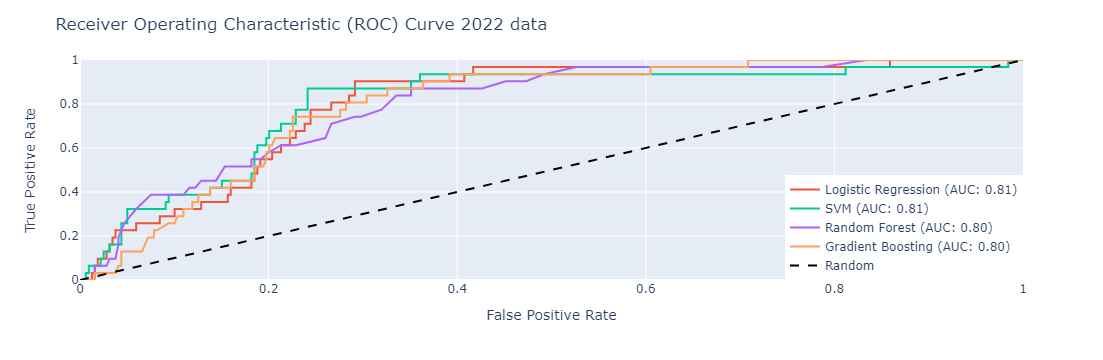

In [338]:
#ROC curve 2022 data
fpr_log, tpr_log, _ = roc_curve(y_test2022_sample, log_classifier.predict_proba(X_test2022_sample)[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_test2022_sample, svm_classifier.predict_proba(X_test2022_sample)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test2022_sample, rf_classifier.predict_proba(X_test2022_sample)[:, 1])
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test2022_sample, gbdt_classifier.predict_proba(X_test2022_sample)[:, 1])

#compute AUC values
auc_log = roc_auc_score(y_test2022_sample, log_classifier.predict_proba(X_test2022_sample)[:, 1])
auc_svm = roc_auc_score(y_test2022_sample, svm_classifier.predict_proba(X_test2022_sample)[:, 1])
auc_rf = roc_auc_score(y_test2022_sample, rf_classifier.predict_proba(X_test2022_sample)[:, 1])
auc_gbdt = roc_auc_score(y_test2022_sample, gbdt_classifier.predict_proba(X_test2022_sample)[:, 1])

#create ROC curves
fig = px.line()
fig.add_scatter(x=fpr_log, y=tpr_log, mode='lines', name=f'Logistic Regression (AUC: {auc_log:.2f})')
fig.add_scatter(x=fpr_svm, y=tpr_svm, mode='lines', name=f'SVM (AUC: {auc_svm:.2f})')
fig.add_scatter(x=fpr_rf, y=tpr_rf, mode='lines', name=f'Random Forest (AUC: {auc_rf:.2f})')
fig.add_scatter(x=fpr_gbdt, y=tpr_gbdt, mode='lines', name=f'Gradient Boosting (AUC: {auc_gbdt:.2f})')
fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random', marker=dict(color='black'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    title='Receiver Operating Characteristic (ROC) Curve 2022 data',
    legend=dict(x=1, y=0, traceorder='normal', yanchor="bottom", xanchor="right")
)

fig.update_yaxes(range=[0, 1])

fig.show()

### Metrics 2023 data

In [339]:
metrics2023 = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test2023_sample, pred2023_log_sample),
        'Precision': precision_score(y_test2023_sample, pred2023_log_sample),
        'Recall': recall_score(y_test2023_sample, pred2023_log_sample),
        'F1 Score': f1_score(y_test2023_sample, pred2023_log_sample),
        'AUC': roc_auc_score(y_test2023_sample, log_classifier.predict_proba(X_test2023_sample)[:, 1])
    },
    'SVM': {
        'Accuracy': accuracy_score(y_test2023_sample, pred2023_svm_sample),
        'Precision': precision_score(y_test2023_sample, pred2023_svm_sample),
        'Recall': recall_score(y_test2023_sample, pred2023_svm_sample),
        'F1 Score': f1_score(y_test2023_sample, pred2023_svm_sample),
        'AUC': roc_auc_score(y_test2023_sample, svm_classifier.predict_proba(X_test2023_sample)[:, 1])
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test2023_sample, pred2023_rf_sample),
        'Precision': precision_score(y_test2023_sample, pred2023_rf_sample),
        'Recall': recall_score(y_test2023_sample, pred2023_rf_sample),
        'F1 Score': f1_score(y_test2023_sample, pred2023_rf_sample),
        'AUC': roc_auc_score(y_test2023_sample, rf_classifier.predict_proba(X_test2023_sample)[:, 1])
    },
    'Gradient Boosting': {
        'Accuracy': accuracy_score(y_test2023_sample, pred2023_gbdt_sample),
        'Precision': precision_score(y_test2023_sample, pred2023_gbdt_sample),
        'Recall': recall_score(y_test2023_sample, pred2023_gbdt_sample),
        'F1 Score': f1_score(y_test2023_sample, pred2023_gbdt_sample),
        'AUC': roc_auc_score(y_test2023_sample, gbdt_classifier.predict_proba(X_test2023_sample)[:, 1])
    }
}

#print metrics
metrics2023 = pd.DataFrame(metrics2023).T

metrics2023

,Accuracy,Precision,Recall,F1 Score,AUC
Logistic Regression,0.908571,0.285714,0.153846,0.200000,0.888889
SVM,0.914286,0.333333,0.153846,0.210526,0.799264
Random Forest,0.905714,0.230769,0.115385,0.153846,0.752552
Gradient Boosting,0.857143,0.071429,0.076923,0.074074,0.743530


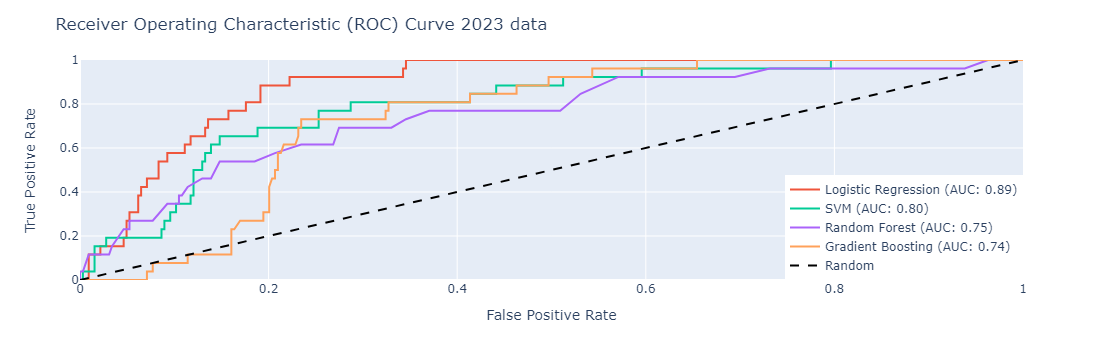

In [340]:
#ROC curve 2023 data
fpr_log, tpr_log, _ = roc_curve(y_test2023_sample, log_classifier.predict_proba(X_test2023_sample)[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_test2023_sample, svm_classifier.predict_proba(X_test2023_sample)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test2023_sample, rf_classifier.predict_proba(X_test2023_sample)[:, 1])
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test2023_sample, gbdt_classifier.predict_proba(X_test2023_sample)[:, 1])

#compute AUC values
auc_log = roc_auc_score(y_test2023_sample, log_classifier.predict_proba(X_test2023_sample)[:, 1])
auc_svm = roc_auc_score(y_test2023_sample, svm_classifier.predict_proba(X_test2023_sample)[:, 1])
auc_rf = roc_auc_score(y_test2023_sample, rf_classifier.predict_proba(X_test2023_sample)[:, 1])
auc_gbdt = roc_auc_score(y_test2023_sample, gbdt_classifier.predict_proba(X_test2023_sample)[:, 1])

#create ROC curves
fig = px.line()
fig.add_scatter(x=fpr_log, y=tpr_log, mode='lines', name=f'Logistic Regression (AUC: {auc_log:.2f})')
fig.add_scatter(x=fpr_svm, y=tpr_svm, mode='lines', name=f'SVM (AUC: {auc_svm:.2f})')
fig.add_scatter(x=fpr_rf, y=tpr_rf, mode='lines', name=f'Random Forest (AUC: {auc_rf:.2f})')
fig.add_scatter(x=fpr_gbdt, y=tpr_gbdt, mode='lines', name=f'Gradient Boosting (AUC: {auc_gbdt:.2f})')
fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random', marker=dict(color='black'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    title='Receiver Operating Characteristic (ROC) Curve 2023 data',
    legend=dict(x=1, y=0, traceorder='normal', yanchor="bottom", xanchor="right")
)
fig.update_yaxes(range=[0, 1])

fig.show()

## Error analysis

### 2022 data

#### Logistic Regression

In [341]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2022_log = np.where((y_test2022_sample == 1) & (pred2022_log_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of LR in 2022: {len(false_negatives2022_log)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2022_log = X_test2022.iloc[false_negatives2022_log]
 
mistake_indices2022_log = X_test_mistakes2022_log.index
 
df_mistakes2022_log = df_KVK2022_original.loc[mistake_indices2022_log]
df_mistakes2022_log

Number of false negatives (mistakes on class 1) of LR in 2022: 22


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
5,15413306.0,senioren advies bureau,1,senioren advies bureau,advies diensten senioren,2009,1,22,1,0,...,0,0,0,0,0,0,0,0,0,0
125,22070818.0,soop,0,soop,welzijnswerk ouderen,2011,2,22,1,0,...,0,0,0,0,0,0,0,1,0,0
132,22616640.0,wilma dijck beweg ouder dans,1,wilma dijck bewegen vo,geven danslessen ouderen verzorgen dansmiddage...,2011,5,11,1,0,...,0,0,0,0,0,0,0,0,0,0
139,24749249.0,judith smeets service,1,judith smeets service,service dienstverlening ouderen single organis...,2012,4,5,1,0,...,0,0,0,0,0,0,0,0,0,0
150,29530032.0,zorg begeleiding westerkwartier,1,zorg begeleiding westerkwartie,zorgverlener welzijnswerk ouderen individuele ...,2014,6,19,1,0,...,0,0,0,0,0,0,0,0,0,0
153,30776171.0,global care capacity bv,6,global care capacity bv,leveren thuis zorg bieden begeleiding zorgvrag...,2014,10,17,1,0,...,0,0,1,0,0,0,0,0,0,0
157,31572774.0,debuurtbutler,1,debuurtbutler,adviseren faciliteren begeleiden senioren,2015,2,5,1,0,...,0,0,0,0,0,0,0,0,0,0
171,37121391.0,huize gaste holding bv,2,huize gaste holding bv,holding activiteiten,2017,5,8,1,0,...,0,0,1,0,0,0,0,0,0,0
173,37376152.0,mantel saman,1,mantel saman,welzijnswerk ouderen helpende zorg welzijn,2017,6,19,1,0,...,0,0,0,0,0,0,0,0,0,0
177,37674331.0,maximum prima care,2,maximum prima care,verlenen zorg huishouden activiteiten begeleid...,2017,8,1,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Support Vector Machine

In [342]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2022_svm = np.where((y_test2022_sample == 1) & (pred2022_svm_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of SVM in 2022: {len(false_negatives2022_svm)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2022_svm = X_test2022.iloc[false_negatives2022_svm]
 
mistake_indices2022_svm = X_test_mistakes2022_svm.index
 
df_mistakes2022_svm = df_KVK2022_original.loc[mistake_indices2022_svm]
df_mistakes2022_svm

Number of false negatives (mistakes on class 1) of SVM in 2022: 24


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
5,15413306.0,senioren advies bureau,1,senioren advies bureau,advies diensten senioren,2009,1,22,1,0,...,0,0,0,0,0,0,0,0,0,0
116,22540636.0,tafeltje dekje,0,tafeltje dekje,welzijnswerk ouderen,2011,4,29,1,0,...,0,0,0,0,0,0,0,1,0,0
120,26780380.0,stichting armen poth,0,stichting armen poth,welzijnszorg bejaarden,2013,2,26,1,0,...,0,0,0,0,0,0,0,1,0,0
122,21573948.0,prot diac stg recreatiefonds spieghelzicht,0,protestantse diaconale stichting,welzijnswerk ouderen alleen subsidie toekennen,2010,12,27,1,0,...,0,0,0,0,0,0,0,1,0,0
125,22070818.0,soop,0,soop,welzijnswerk ouderen,2011,2,22,1,0,...,0,0,0,0,0,0,0,1,0,0
132,22616640.0,wilma dijck beweg ouder dans,1,wilma dijck bewegen vo,geven danslessen ouderen verzorgen dansmiddage...,2011,5,11,1,0,...,0,0,0,0,0,0,0,0,0,0
139,24749249.0,judith smeets service,1,judith smeets service,service dienstverlening ouderen single organis...,2012,4,5,1,0,...,0,0,0,0,0,0,0,0,0,0
149,30000815.0,theo s aim art motion,1,theo s aim art motion,verrichten diverse werkzaamheden gezondheidszo...,2014,6,11,1,0,...,0,0,0,0,0,0,0,0,0,0
150,29530032.0,zorg begeleiding westerkwartier,1,zorg begeleiding westerkwartie,zorgverlener welzijnswerk ouderen individuele ...,2014,6,19,1,0,...,0,0,0,0,0,0,0,0,0,0
153,30776171.0,global care capacity bv,6,global care capacity bv,leveren thuis zorg bieden begeleiding zorgvrag...,2014,10,17,1,0,...,0,0,1,0,0,0,0,0,0,0


#### Random Forest

In [343]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2022_rf = np.where((y_test2022_sample == 1) & (pred2022_rf_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of RF in 2022: {len(false_negatives2022_rf)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2022_rf = X_test2022.iloc[false_negatives2022_rf]
 
mistake_indices2022_rf = X_test_mistakes2022_rf.index
 
df_mistakes2022_rf = df_KVK2022_original.loc[mistake_indices2022_rf]
df_mistakes2022_rf

Number of false negatives (mistakes on class 1) of RF in 2022: 26


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
5,15413306.0,senioren advies bureau,1,senioren advies bureau,advies diensten senioren,2009,1,22,1,0,...,0,0,0,0,0,0,0,0,0,0
89,21565562.0,stichting algemene hulpdienst venray,0,stichting algemene hulpdienst ve,helpen gevallen omstandigheden waar hulp karak...,2010,12,27,1,0,...,0,0,0,0,0,0,0,1,0,0
116,22540636.0,tafeltje dekje,0,tafeltje dekje,welzijnswerk ouderen,2011,4,29,1,0,...,0,0,0,0,0,0,0,1,0,0
120,26780380.0,stichting armen poth,0,stichting armen poth,welzijnszorg bejaarden,2013,2,26,1,0,...,0,0,0,0,0,0,0,1,0,0
122,21573948.0,prot diac stg recreatiefonds spieghelzicht,0,protestantse diaconale stichting,welzijnswerk ouderen alleen subsidie toekennen,2010,12,27,1,0,...,0,0,0,0,0,0,0,1,0,0
125,22070818.0,soop,0,soop,welzijnswerk ouderen,2011,2,22,1,0,...,0,0,0,0,0,0,0,1,0,0
132,22616640.0,wilma dijck beweg ouder dans,1,wilma dijck bewegen vo,geven danslessen ouderen verzorgen dansmiddage...,2011,5,11,1,0,...,0,0,0,0,0,0,0,0,0,0
139,24749249.0,judith smeets service,1,judith smeets service,service dienstverlening ouderen single organis...,2012,4,5,1,0,...,0,0,0,0,0,0,0,0,0,0
149,30000815.0,theo s aim art motion,1,theo s aim art motion,verrichten diverse werkzaamheden gezondheidszo...,2014,6,11,1,0,...,0,0,0,0,0,0,0,0,0,0
150,29530032.0,zorg begeleiding westerkwartier,1,zorg begeleiding westerkwartie,zorgverlener welzijnswerk ouderen individuele ...,2014,6,19,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Gradient Boosting Trees

In [344]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2022_gbdt = np.where((y_test2022_sample == 1) & (pred2022_gbdt_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of GBDT in 2022: {len(false_negatives2022_gbdt)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2022_gbdt = X_test2022.iloc[false_negatives2022_gbdt]
 
mistake_indices2022_gbdt = X_test_mistakes2022_gbdt.index
 
df_mistakes2022_gbdt = df_KVK2022_original.loc[mistake_indices2022_gbdt]
df_mistakes2022_gbdt

Number of false negatives (mistakes on class 1) of GBDT in 2022: 30


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
5,15413306.0,senioren advies bureau,1,senioren advies bureau,advies diensten senioren,2009,1,22,1,0,...,0,0,0,0,0,0,0,0,0,0
89,21565562.0,stichting algemene hulpdienst venray,0,stichting algemene hulpdienst ve,helpen gevallen omstandigheden waar hulp karak...,2010,12,27,1,0,...,0,0,0,0,0,0,0,1,0,0
116,22540636.0,tafeltje dekje,0,tafeltje dekje,welzijnswerk ouderen,2011,4,29,1,0,...,0,0,0,0,0,0,0,1,0,0
118,21987203.0,stichting cosbo stad utrecht,0,stichting cosbo stad utrecht,overige instellingen gebied maatschappelijk ad...,2011,2,10,1,0,...,0,0,0,0,0,0,0,1,0,0
120,26780380.0,stichting armen poth,0,stichting armen poth,welzijnszorg bejaarden,2013,2,26,1,0,...,0,0,0,0,0,0,0,1,0,0
122,21573948.0,prot diac stg recreatiefonds spieghelzicht,0,protestantse diaconale stichting,welzijnswerk ouderen alleen subsidie toekennen,2010,12,27,1,0,...,0,0,0,0,0,0,0,1,0,0
125,22070818.0,soop,0,soop,welzijnswerk ouderen,2011,2,22,1,0,...,0,0,0,0,0,0,0,1,0,0
132,22616640.0,wilma dijck beweg ouder dans,1,wilma dijck bewegen vo,geven danslessen ouderen verzorgen dansmiddage...,2011,5,11,1,0,...,0,0,0,0,0,0,0,0,0,0
139,24749249.0,judith smeets service,1,judith smeets service,service dienstverlening ouderen single organis...,2012,4,5,1,0,...,0,0,0,0,0,0,0,0,0,0
149,30000815.0,theo s aim art motion,1,theo s aim art motion,verrichten diverse werkzaamheden gezondheidszo...,2014,6,11,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Common errors

In [345]:
#identify the common indices
common_indices = list(set(df_mistakes2022_log.index) &
                      set(df_mistakes2022_svm.index) &
                      set(df_mistakes2022_rf.index) &
                      set(df_mistakes2022_gbdt.index))

#subset each df using the common indices
df_log_common = df_mistakes2022_log.loc[common_indices]
df_svm_common = df_mistakes2022_svm.loc[common_indices]
df_rf_common = df_mistakes2022_rf.loc[common_indices]
df_gbdt_common = df_mistakes2022_gbdt.loc[common_indices]

#concatenate the df to store the common rows
#check if they have the same columns
assert df_log_common.columns.equals(df_svm_common.columns)
assert df_log_common.columns.equals(df_rf_common.columns)
assert df_log_common.columns.equals(df_gbdt_common.columns)

#concatenate the df while avoiding column duplication
df_common_mistakes2022 = pd.concat([df_log_common, df_svm_common.drop(columns=df_log_common.columns), 
                                    df_rf_common.drop(columns=df_log_common.columns), 
                                    df_gbdt_common.drop(columns=df_log_common.columns)], axis=1)

df_common_mistakes2022

,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
226,11035986.0,corlian mooibroek,1,corlian mooibroek,begeleiden verzorgen kinderen jongeren beperki...,2008,8,8,0,1,...,0,0,0,0,0,0,0,0,0,0
132,22616640.0,wilma dijck beweg ouder dans,1,wilma dijck bewegen vo,geven danslessen ouderen verzorgen dansmiddage...,2011,5,11,1,0,...,0,0,0,0,0,0,0,0,0,0
5,15413306.0,senioren advies bureau,1,senioren advies bureau,advies diensten senioren,2009,1,22,1,0,...,0,0,0,0,0,0,0,0,0,0
297,6002323.0,solocare,1,solocare,activeren ondersteunende begeleiding geven men...,2008,12,29,0,1,...,0,0,0,0,0,0,0,0,0,0
139,24749249.0,judith smeets service,1,judith smeets service,service dienstverlening ouderen single organis...,2012,4,5,1,0,...,0,0,0,0,0,0,0,0,0,0
267,9241892.0,z zolder,1,z zolder,ambulante begeleiding ondersteuning gehandicap...,2008,3,7,0,1,...,0,0,0,0,0,0,0,0,0,0
207,48384003.0,wegdam mantelzorg bv,1,wegdam mantelzorg bv,bieden particuliere mantelzorg personen aanvul...,2021,3,9,1,0,...,0,0,1,0,0,0,0,0,0,0
177,37674331.0,maximum prima care,2,maximum prima care,verlenen zorg huishouden activiteiten begeleid...,2017,8,1,1,0,...,0,0,0,0,0,0,0,0,0,0
212,50084968.0,dani ouderenzorg,1,dani ouderenzorg,ouderenzorg,2021,9,20,1,0,...,0,0,0,0,0,0,0,0,0,0
213,50129481.0,zorgboerderij willemshoeve,1,zorgboerderij willemshoeve,dagbesteding ouderen,2021,9,24,1,0,...,0,0,0,0,0,0,0,0,0,0


### 2023 data

#### Logistic Regression

In [346]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2023_log = np.where((y_test2023_sample == 1) & (pred2023_log_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of LR in 2023: {len(false_negatives2023_log)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2023_log = X_test2023.iloc[false_negatives2023_log]
 
mistake_indices2023_log = X_test_mistakes2023_log.index
 
df_mistakes2023_log = df_KVK2023_original.loc[mistake_indices2023_log]
df_mistakes2023_log

Number of false negatives (mistakes on class 1) of LR in 2023: 22


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
2,12799750.0,stichting mienskipssintrum it geahus,6,stichting mienskipssintrum it geahus,oprichting instandhouding exploiteren gebouw t...,1965,9,30,0,0,...,0,0,0,0,0,0,0,1,0,0
9,6870295.0,cooperatieve vereniging warena ua,0,cooperatieve vereniging warena ua,gebruik geven percelen grond kavels tbv recrea...,1988,8,12,0,0,...,0,0,0,1,0,0,0,0,0,0
20,6968597.0,vastgoed trynwalden mak taxaties beheer,1,vastgoed trynwalden makelaardij taxaties beheer,bemiddeling verkoop huur verhuur onroerende za...,1995,9,19,0,0,...,0,0,0,0,0,0,0,0,0,0
31,22336788.0,helling,0,helling,exploitatie gemeenschaps dorpshuizen wijkcentr...,2011,3,30,0,0,...,0,0,0,0,0,0,0,1,0,0
40,57046298.0,stichting woongroep,0,stichting woongroep,zorg verlenen volwassenen verstandelijke beper...,2023,9,14,0,1,...,0,0,0,0,0,0,0,1,0,0
65,11756799.0,pakketterie,2,pakketterie,exploitatie cadeaushop begeleiden mensen verst...,2005,4,21,0,0,...,1,0,0,0,0,0,0,0,0,0
111,13378228.0,miranda zorgt,1,miranda zorgt,verlenen zorg enof begeleiding personen persoo...,2007,12,27,0,0,...,0,0,0,0,0,0,0,0,0,0
167,9875557.0,liesbeth schippers counselling coaching,1,liesbeth schippers counselling coaching,counselling coaching bieden begeleiding prive ...,2008,9,5,0,0,...,0,0,0,0,0,0,0,0,0,0
168,2306883.0,renate martini,1,renate martini,ontwerpstudio kleuradviezen wandschilderingen ...,2008,10,6,0,0,...,0,0,0,0,0,0,0,0,0,0
169,14966441.0,jeltes bouwadvies,1,jeltes bouwadvies,adviesbureau bouwactiviteiten bouw projectmana...,2008,10,13,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Support Vector Machine

In [347]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2023_svm = np.where((y_test2023_sample == 1) & (pred2023_svm_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of SVM in 2023: {len(false_negatives2023_svm)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2023_svm = X_test2023.iloc[false_negatives2023_svm]
 
mistake_indices2023_svm = X_test_mistakes2023_svm.index
 
df_mistakes2023_svm = df_KVK2023_original.loc[mistake_indices2023_svm]
df_mistakes2023_svm

Number of false negatives (mistakes on class 1) of SVM in 2023: 22


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
2,12799750.0,stichting mienskipssintrum it geahus,6,stichting mienskipssintrum it geahus,oprichting instandhouding exploiteren gebouw t...,1965,9,30,0,0,...,0,0,0,0,0,0,0,1,0,0
31,22336788.0,helling,0,helling,exploitatie gemeenschaps dorpshuizen wijkcentr...,2011,3,30,0,0,...,0,0,0,0,0,0,0,1,0,0
40,57046298.0,stichting woongroep,0,stichting woongroep,zorg verlenen volwassenen verstandelijke beper...,2023,9,14,0,1,...,0,0,0,0,0,0,0,1,0,0
53,13589482.0,allium voedingtekst advies,1,allium voedingtekst advies,voorlichting advies gezonde voeding biologisch...,2003,7,3,0,0,...,0,0,0,0,0,0,0,0,0,0
65,11756799.0,pakketterie,2,pakketterie,exploitatie cadeaushop begeleiden mensen verst...,2005,4,21,0,0,...,1,0,0,0,0,0,0,0,0,0
111,13378228.0,miranda zorgt,1,miranda zorgt,verlenen zorg enof begeleiding personen persoo...,2007,12,27,0,0,...,0,0,0,0,0,0,0,0,0,0
164,14171392.0,verbinding,1,verbinding,praktijk relatie gezinstherapie specifiek aanb...,2008,8,29,0,0,...,0,0,0,0,0,0,0,0,0,0
167,9875557.0,liesbeth schippers counselling coaching,1,liesbeth schippers counselling coaching,counselling coaching bieden begeleiding prive ...,2008,9,5,0,0,...,0,0,0,0,0,0,0,0,0,0
168,2306883.0,renate martini,1,renate martini,ontwerpstudio kleuradviezen wandschilderingen ...,2008,10,6,0,0,...,0,0,0,0,0,0,0,0,0,0
169,14966441.0,jeltes bouwadvies,1,jeltes bouwadvies,adviesbureau bouwactiviteiten bouw projectmana...,2008,10,13,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Random Forest

In [348]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2023_rf = np.where((y_test2023_sample == 1) & (pred2023_rf_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of RF in 2023: {len(false_negatives2023_rf)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2023_rf = X_test2023.iloc[false_negatives2023_rf]
 
mistake_indices2023_rf = X_test_mistakes2023_rf.index
 
df_mistakes2023_rf = df_KVK2023_original.loc[mistake_indices2023_rf]
df_mistakes2023_rf

Number of false negatives (mistakes on class 1) of RF in 2023: 23


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
2,12799750.0,stichting mienskipssintrum it geahus,6,stichting mienskipssintrum it geahus,oprichting instandhouding exploiteren gebouw t...,1965,9,30,0,0,...,0,0,0,0,0,0,0,1,0,0
9,6870295.0,cooperatieve vereniging warena ua,0,cooperatieve vereniging warena ua,gebruik geven percelen grond kavels tbv recrea...,1988,8,12,0,0,...,0,0,0,1,0,0,0,0,0,0
20,6968597.0,vastgoed trynwalden mak taxaties beheer,1,vastgoed trynwalden makelaardij taxaties beheer,bemiddeling verkoop huur verhuur onroerende za...,1995,9,19,0,0,...,0,0,0,0,0,0,0,0,0,0
31,22336788.0,helling,0,helling,exploitatie gemeenschaps dorpshuizen wijkcentr...,2011,3,30,0,0,...,0,0,0,0,0,0,0,1,0,0
40,57046298.0,stichting woongroep,0,stichting woongroep,zorg verlenen volwassenen verstandelijke beper...,2023,9,14,0,1,...,0,0,0,0,0,0,0,1,0,0
53,13589482.0,allium voedingtekst advies,1,allium voedingtekst advies,voorlichting advies gezonde voeding biologisch...,2003,7,3,0,0,...,0,0,0,0,0,0,0,0,0,0
65,11756799.0,pakketterie,2,pakketterie,exploitatie cadeaushop begeleiden mensen verst...,2005,4,21,0,0,...,1,0,0,0,0,0,0,0,0,0
111,13378228.0,miranda zorgt,1,miranda zorgt,verlenen zorg enof begeleiding personen persoo...,2007,12,27,0,0,...,0,0,0,0,0,0,0,0,0,0
164,14171392.0,verbinding,1,verbinding,praktijk relatie gezinstherapie specifiek aanb...,2008,8,29,0,0,...,0,0,0,0,0,0,0,0,0,0
168,2306883.0,renate martini,1,renate martini,ontwerpstudio kleuradviezen wandschilderingen ...,2008,10,6,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Gradient Boosting Trees

In [349]:
#find the indices where the true label is 1 but the predicted label is 0 (false negatives)
false_negatives2023_gbdt = np.where((y_test2023_sample == 1) & (pred2023_gbdt_sample == 0))[0]
 
#print the number of mistakes
print(f"Number of false negatives (mistakes on class 1) of GBDT in 2023: {len(false_negatives2023_gbdt)}")
 
#extract the corresponding instances from X_test where the mistakes occurred
X_test_mistakes2023_gbdt = X_test2023.iloc[false_negatives2023_gbdt]
 
mistake_indices2023_gbdt = X_test_mistakes2023_gbdt.index
 
df_mistakes2023_gbdt = df_KVK2023_original.loc[mistake_indices2023_gbdt]
df_mistakes2023_gbdt

Number of false negatives (mistakes on class 1) of GBDT in 2023: 24


,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
2,12799750.0,stichting mienskipssintrum it geahus,6,stichting mienskipssintrum it geahus,oprichting instandhouding exploiteren gebouw t...,1965,9,30,0,0,...,0,0,0,0,0,0,0,1,0,0
9,6870295.0,cooperatieve vereniging warena ua,0,cooperatieve vereniging warena ua,gebruik geven percelen grond kavels tbv recrea...,1988,8,12,0,0,...,0,0,0,1,0,0,0,0,0,0
20,6968597.0,vastgoed trynwalden mak taxaties beheer,1,vastgoed trynwalden makelaardij taxaties beheer,bemiddeling verkoop huur verhuur onroerende za...,1995,9,19,0,0,...,0,0,0,0,0,0,0,0,0,0
31,22336788.0,helling,0,helling,exploitatie gemeenschaps dorpshuizen wijkcentr...,2011,3,30,0,0,...,0,0,0,0,0,0,0,1,0,0
40,57046298.0,stichting woongroep,0,stichting woongroep,zorg verlenen volwassenen verstandelijke beper...,2023,9,14,0,1,...,0,0,0,0,0,0,0,1,0,0
53,13589482.0,allium voedingtekst advies,1,allium voedingtekst advies,voorlichting advies gezonde voeding biologisch...,2003,7,3,0,0,...,0,0,0,0,0,0,0,0,0,0
65,11756799.0,pakketterie,2,pakketterie,exploitatie cadeaushop begeleiden mensen verst...,2005,4,21,0,0,...,1,0,0,0,0,0,0,0,0,0
111,13378228.0,miranda zorgt,1,miranda zorgt,verlenen zorg enof begeleiding personen persoo...,2007,12,27,0,0,...,0,0,0,0,0,0,0,0,0,0
152,11779136.0,hdj consultancy,1,hdj consultancy,counseling coaching gastouder werkzaam pgb web...,2008,7,1,0,0,...,0,0,0,0,0,0,0,0,0,0
164,14171392.0,verbinding,1,verbinding,praktijk relatie gezinstherapie specifiek aanb...,2008,8,29,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Common errors

In [350]:
#identify the common indices
common_indices = list(set(df_mistakes2023_log.index) &
                      set(df_mistakes2023_svm.index) &
                      set(df_mistakes2023_rf.index) &
                      set(df_mistakes2023_gbdt.index))

#subset each df using the common indices
df_log_common = df_mistakes2023_log.loc[common_indices]
df_svm_common = df_mistakes2023_svm.loc[common_indices]
df_rf_common = df_mistakes2023_rf.loc[common_indices]
df_gbdt_common = df_mistakes2023_gbdt.loc[common_indices]

#concatenate the df to store the common rows
#check if they have the same columns
assert df_log_common.columns.equals(df_svm_common.columns)
assert df_log_common.columns.equals(df_rf_common.columns)
assert df_log_common.columns.equals(df_gbdt_common.columns)

#concatenate the df while avoiding column duplication
df_common_mistakes2023 = pd.concat([df_log_common, df_svm_common.drop(columns=df_log_common.columns), 
                                    df_rf_common.drop(columns=df_log_common.columns), 
                                    df_gbdt_common.drop(columns=df_log_common.columns)], axis=1)

df_common_mistakes2023

,VGNUMMER,HN45,W_P_TOTAAL,H_NAAM_VOL,Bedrijfsomschrijving,INSCHR_DAT_JAAR,INSCHR_DAT_MAAND,INSCHR_DAT_DAG,SBI_88102,SBI_88103,...,rechtsvorm_11,rechtsvorm_21,rechtsvorm_41,rechtsvorm_61,rechtsvorm_70,rechtsvorm_71,rechtsvorm_72,rechtsvorm_74,rechtsvorm_88,rechtsvorm_overig
2,12799750.0,stichting mienskipssintrum it geahus,6,stichting mienskipssintrum it geahus,oprichting instandhouding exploiteren gebouw t...,1965,9,30,0,0,...,0,0,0,0,0,0,0,1,0,0
266,650285.0,tapilatu training coaching,1,tapilatu training coaching,advisering coaching begeleiding gebied trainin...,2010,2,10,0,0,...,0,0,0,0,0,0,0,0,0,0
267,3926095.0,praktijk vitamien,2,praktijk vitamien,praktijk coaching alternatieve psychotherapie ...,2010,2,12,0,0,...,1,0,0,0,0,0,0,0,0,0
282,7985606.0,coop woonver middelhorst ua,0,cooperatieve woonvereniging middelhorst ua,gebruik afstaan woningen wooneenheden leden,1952,5,30,0,0,...,0,0,0,1,0,0,0,0,0,0
31,22336788.0,helling,0,helling,exploitatie gemeenschaps dorpshuizen wijkcentr...,2011,3,30,0,0,...,0,0,0,0,0,0,0,1,0,0
40,57046298.0,stichting woongroep,0,stichting woongroep,zorg verlenen volwassenen verstandelijke beper...,2023,9,14,0,1,...,0,0,0,0,0,0,0,1,0,0
168,2306883.0,renate martini,1,renate martini,ontwerpstudio kleuradviezen wandschilderingen ...,2008,10,6,0,0,...,0,0,0,0,0,0,0,0,0,0
169,14966441.0,jeltes bouwadvies,1,jeltes bouwadvies,adviesbureau bouwactiviteiten bouw projectmana...,2008,10,13,0,0,...,0,0,0,0,0,0,0,0,0,0
174,3469611.0,studiocolore,1,studiocolore,creatieve therapie coaching begeleiding pgb wm...,2008,11,18,0,0,...,0,0,0,0,0,0,0,0,0,0
178,13031074.0,durksz,1,durksz,organisatieadviesbureau geestelijk advies advi...,2014,6,26,0,0,...,0,0,0,0,0,0,0,0,0,0


# Using the best performing classifier

After finding the best performing classifier, it is interesting to see what the actual results are that this model outputs. We want to know how many caring communities this model predict for both the 2022 and 2023 datasets and with which confidence bounds.

In [351]:
unique, counts = np.unique(pred2022_svm, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0 7279]
 [   1  407]]


407 caring communities in the 2022 dataset

In [352]:
unique, counts = np.unique(pred2023_svm, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 10547]
 [    1   528]]


528 caring communities in the 2023 dataset

In [353]:
def calculate_confidence_interval(y_pred, confidence_level=0.95):
    total_predictions = len(y_pred)            #total number of predictions
    class_1_predictions = sum(y_pred == 1)     #number of class 1 predictions
    p_hat = class_1_predictions / total_predictions #proportion of class 1 predictions
    standard_error = np.sqrt(p_hat * (1 - p_hat) / total_predictions)
    z_score = norm.ppf(1 - (1 - confidence_level) / 2)
    margin_of_error = z_score * standard_error 
    confidence_interval_proportion = (p_hat - margin_of_error, p_hat + margin_of_error)

    #convert the confidence interval for the proportion to a confidence interval for the count
    confidence_interval_count = (
        confidence_interval_proportion[0] * total_predictions,
        confidence_interval_proportion[1] * total_predictions
    )

    #print the results
    print(f"Number of class 1 predictions: {class_1_predictions}")
    print(f"Proportion of class 1 predictions: {p_hat}")
    print(f"Standard Error: {standard_error}")
    print(f"{int(confidence_level * 100)}% Confidence Interval for Proportion: {confidence_interval_proportion}")
    print(f"{int(confidence_level * 100)}% Confidence Interval for Count: {confidence_interval_count}")

    return {
        "class_1_predictions": class_1_predictions,
        "proportion": p_hat,
        "standard_error": standard_error,
        "confidence_interval_proportion": confidence_interval_proportion,
        "confidence_interval_count": confidence_interval_count
    }

results_2022 = calculate_confidence_interval(pred2022_svm, confidence_level=0.95)
results_2023 = calculate_confidence_interval(pred2023_svm, confidence_level=0.95)

Number of class 1 predictions: 407
Proportion of class 1 predictions: 0.05295342180588082
Standard Error: 0.0025543622900720524
95% Confidence Interval for Proportion: (0.047946963713872345, 0.057959879897889297)
95% Confidence Interval for Count: (368.5203631048228, 445.4796368951771)
Number of class 1 predictions: 528
Proportion of class 1 predictions: 0.047674943566591424
Standard Error: 0.0020247240053261344
95% Confidence Interval for Proportion: (0.043706557437518515, 0.05164332969566433)
95% Confidence Interval for Count: (484.0501236205175, 571.9498763794825)


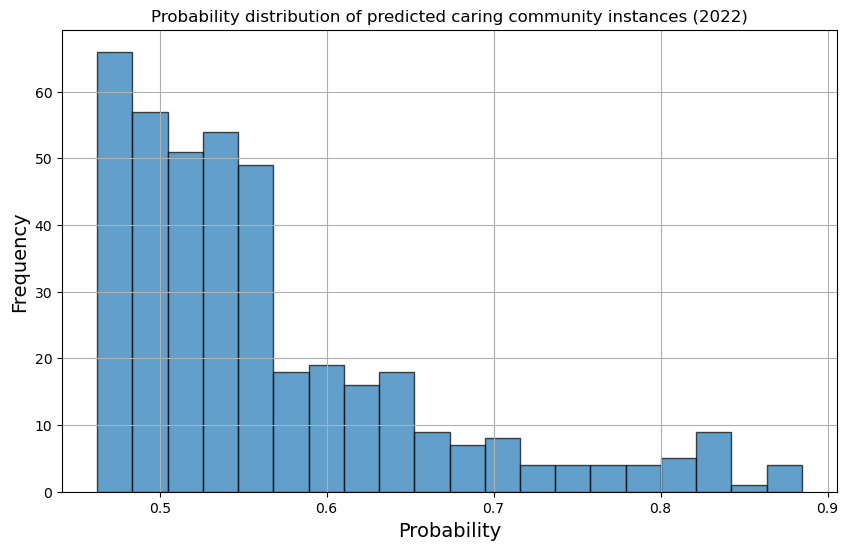

In [354]:
#get the probability estimates for all instances
probabilities = svm_classifier.predict_proba(X_test2022)
 
#convert the NumPy array to a Pandas DataFrame for easier manipulation
prob_df = pd.DataFrame(probabilities, columns=[f'class_{i}' for i in range(probabilities.shape[1])])
 
#extract the instances where the prediction is class 1
predicted_class_1_indices = pred2022_svm == 1
 
#get the probabilities for class 1 for these instances
class_1_probabilities = prob_df.loc[predicted_class_1_indices, 'class_1']
 
#plot the distribution of the probabilities
plt.figure(figsize=(10, 6))
plt.hist(class_1_probabilities, bins=20, edgecolor='k', alpha=0.7)
plt.title('Probability distribution of predicted caring community instances (2022)')
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.grid(True)
plt.savefig('probability_distribution_2022.png')
 
plt.show()

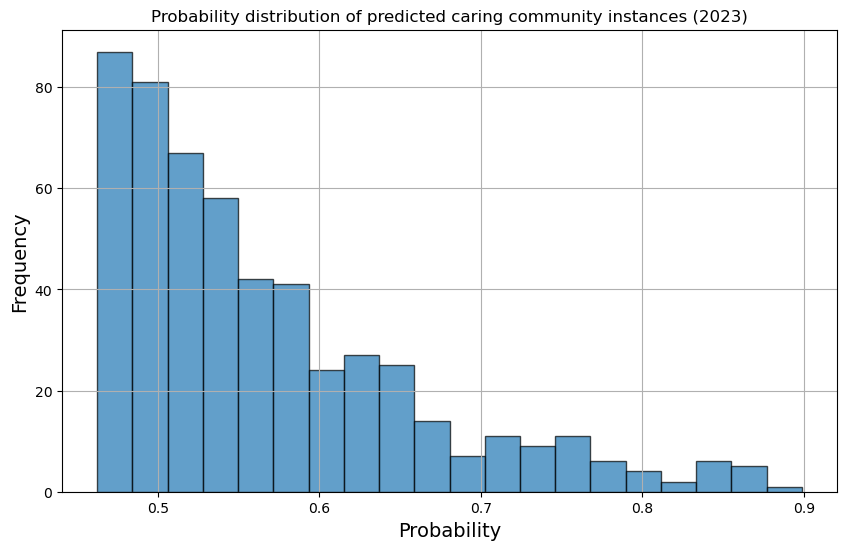

In [355]:
#get the probability estimates for all instances
probabilities = svm_classifier.predict_proba(X_test2023)
 
#convert the NumPy array to a Pandas DataFrame for easier manipulation
prob_df = pd.DataFrame(probabilities, columns=[f'class_{i}' for i in range(probabilities.shape[1])])
 
#extract the instances where the prediction is class 1
predicted_class_1_indices = pred2023_svm == 1
 
#get the probabilities for class 1 for these instances
class_1_probabilities = prob_df.loc[predicted_class_1_indices, 'class_1']
 
#plot the distribution of the probabilities
plt.figure(figsize=(10, 6))
plt.hist(class_1_probabilities, bins=20, edgecolor='k', alpha=0.7)
plt.title('Probability distribution of predicted caring community instances (2023)')
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.grid(True)
plt.savefig('probability_distribution_2023.png')
 
plt.show()

In [356]:
#get the probability estimates for all instances
probabilities = svm_classifier.predict_proba(X_test2022)
 
#converting numpy to pandas dataframe
prob_df = pd.DataFrame(probabilities, columns=[f'class_{i}' for i in range(probabilities.shape[1])])
 
#extract the instances where the prediction is class 1
predicted_class_1_indices = pred2022_svm == 1
 
#get the probabilities for class1 instances
class_1_probabilities = prob_df.loc[predicted_class_1_indices, 'class_1']
 
#create a new DataFrame to store the indices and probabilities
results_df = pd.DataFrame({
    'index': prob_df.index[predicted_class_1_indices],
    'probability': class_1_probabilities
})
 
#merge the probabilities with the original DataFrame 
df_KVK2022_with_probs = df_KVK2022_original.merge(results_df, left_index=True, right_on='index', how='inner')
 
#drop index and combined text column
df_KVK2022_with_probs.drop(columns=['index'], inplace=True)
 
#sort by probability
df_KVK2022_probs_sorted = df_KVK2022_with_probs.sort_values(by='probability', ascending=False)
df_KVK2022_probs_sorted
df_KVK2022_probs_sorted.to_excel('df_KVK2022_with_probs.xlsx', index=False)

In [357]:
#get the probability estimates for all instances
probabilities = svm_classifier.predict_proba(X_test2023)
 
#converting numpy to pandas dataframe
prob_df = pd.DataFrame(probabilities, columns=[f'class_{i}' for i in range(probabilities.shape[1])])
 
#extract the instances where the prediction is class 1
predicted_class_1_indices = pred2023_svm == 1
 
#get the probabilities for class1 instances
class_1_probabilities = prob_df.loc[predicted_class_1_indices, 'class_1']
 
#create a new DataFrame to store the indices and probabilities
results_df = pd.DataFrame({
    'index': prob_df.index[predicted_class_1_indices],
    'probability': class_1_probabilities
})
 
#merge the probabilities with the original DataFrame 
df_KVK2023_with_probs = df_KVK2023_original.merge(results_df, left_index=True, right_on='index', how='inner')
 
#drop index and combined text column
df_KVK2023_with_probs.drop(columns=['index'], inplace=True)
 
#sort by probability
df_KVK2023_probs_sorted = df_KVK2023_with_probs.sort_values(by='probability', ascending=False)
df_KVK2023_probs_sorted
df_KVK2023_probs_sorted.to_excel('df_KVK2023_with_probs.xlsx', index=False)